In [1]:
# === SECTION 1: Imports and Configuration ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.stats import norm
from scipy.interpolate import griddata, interp1d
from sklearn.linear_model import LassoCV

# Configuration
TRADING_DAYS_PER_MONTH = 21
OPTIONS_PARQUET = "../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../data/OMunderlying.csv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [2]:
df_1m_filtered = pd.read_csv('FilteredDataset.csv', index_col=0)
df_1m_filtered['date'] = pd.to_datetime(df_1m_filtered['date'])
df_1m_filtered['exdate'] = pd.to_datetime(df_1m_filtered['exdate'])
print(f"\nFinal filtered dataset: {len(df_1m_filtered)} rows")
df_1m_filtered.head(10)


Final filtered dataset: 28073947 rows


date     exdate cp_flag  strike_price     spot  moneyness  dte  \
0 2000-01-03 2000-01-22       P        1275.0  1455.22   0.876156   19   
1 2000-01-03 2000-01-22       P        1300.0  1455.22   0.893336   19   
2 2000-01-03 2000-01-22       P        1325.0  1455.22   0.910515   19   
3 2000-01-03 2000-01-22       C        1325.0  1455.22   0.910515   19   
4 2000-01-03 2000-01-22       C        1350.0  1455.22   0.927695   19   
5 2000-01-03 2000-01-22       P        1350.0  1455.22   0.927695   19   
6 2000-01-03 2000-01-22       C        1375.0  1455.22   0.944874   19   
7 2000-01-03 2000-01-22       P        1375.0  1455.22   0.944874   19   
8 2000-01-03 2000-01-22       C        1380.0  1455.22   0.948310   19   
9 2000-01-03 2000-01-22       P        1380.0  1455.22   0.948310   19   

        mid  best_bid  best_offer  volume  open_interest     delta      vega  \
0    2.0000     1.750       2.250     585          23785 -0.041295  28.57753   
1    2.6250     2.250       3.000    3572          26621 -0.055490  36.20153   
2    3.8125     3.500       4.125    1406          30757 -0.079749  47.92918   
3  134.5000   133.500     135.500     315          29529  0.983012  13.61578   
4  111.1250   110.125     112.125     112          20500  0.939732  38.63064   
5    5.1875     4.875       5.500     819          24413 -0.109956  60.74824   
6   88.5000    87.500      89.500       6           7885  0.884385  62.96457   
7    6.9375     6.750       7.125    2633          18270 -0.150684  75.57642   
8   84.0000    83.000      85.000       4             13  0.872528  67.43791   
9    8.1250     7.625       8.625      69           1458 -0.168821  81.41239   

   impl_volatility  spread  rel_spread  
0         0.358787   0.500    0.250000  
1         0.334738   0.750    0.285714  
2         0.317378   0.625    0.163934  
3         0.207545   2.000    0.014870  
4         0.229941   2.000    0.017998  
5         0.294041   0.625    0.120482  
6         0.229135   2.000    0.022599  
7         0.267472   0.375    0.054054  
8         0.226489   2.000    0.023810  
9         0.271506   1.000    0.123077

In [ ]:
surf_df = pd.read_csv("surfacesTransform.csv", index_col="date")

# Extract as numpy array
surfaces_transform = surf_df.values
dates_volgan = pd.to_datetime(surf_df.index)

print(f"Loaded surfacesTransform.csv with shape: {surfaces_transform.shape}")
print(f"Date range: {dates_volgan[0].date()} → {dates_volgan[-1].date()}")
m = np.linspace(0.6, 1.4, 10)
dte_grid = [7, 14, 30, 60, 91, 122, 152, 182]
tau = np.array(dte_grid) / 365.0



Loaded surfacesTransform.csv with shape: (5954, 80)
Date range: 2000-01-03 → 2023-08-31


In [4]:
df_spot = pd.read_csv(OM_UNDERLYING_CSV)
df_spot['date'] = pd.to_datetime(df_spot['date'])
df_spot = df_spot[df_spot['ticker'] == 'SPX'][['date', 'close']].rename(columns={'close': 'spot'})
df_spot = df_spot.drop_duplicates('date').sort_values('date')
df_underlying = df_spot

In [5]:
# === SECTION 5: Prepare VolGAN Training Data ===

def prepare_volgan_data_om(surfaces, dates_list, df_spot):
    """Prepare condition and target arrays for VolGAN."""
    dates_pd = pd.to_datetime(dates_list)
    spot_df = df_spot[df_spot['date'].isin(dates_pd)].sort_values('date')
    prices = spot_df['spot'].values
    
    prices_prev = np.zeros(len(prices))
    prices_prev[1:] = prices[:-1]
    prices_prev[0] = prices[0]
    log_rtn = np.log(prices) - np.log(prices_prev)
    
    realised_vol_tm1 = np.zeros(len(log_rtn) - 22)
    for i in range(len(realised_vol_tm1)):
        realised_vol_tm1[i] = np.sqrt(252 / 21) * np.sqrt(np.sum(log_rtn[i:(i+21)]**2))
    
    # ALL use [21:-1] for 5009 samples
    dates_t = dates_pd[21:-1]
    log_rtn_t = log_rtn[22:]     # This is NOW 5009 (indices 22 to end-1)
    log_rtn_tm1 = log_rtn[21:-1] 
    log_rtn_tm2 = log_rtn[20:-2]
    
    log_iv_t = np.log(surfaces[22:])
    log_iv_tm1 = np.log(surfaces[21:-1])
    log_iv_inc_t = log_iv_t - log_iv_tm1
    
    condition = np.concatenate((
        np.expand_dims(log_rtn_tm1, axis=1),
        np.expand_dims(log_rtn_tm2, axis=1),
        np.expand_dims(realised_vol_tm1, axis=1),
        log_iv_tm1
    ), axis=1)
    
    true = np.concatenate((
        np.expand_dims(log_rtn_t, axis=1),
        log_iv_inc_t
    ), axis=1)
    
    return true, condition, dates_t

true, condition, dates_volgan_aligned = prepare_volgan_data_om(
    surfaces_transform, dates_volgan, df_underlying
)
print(f"VolGAN data shapes: true={true.shape}, condition={condition.shape}")
# After prepare_volgan_data_om:
print("Sample condition features:")
print(f"  r_tm1: mean={condition[:, 0].mean():.4f}, std={condition[:, 0].std():.4f}")
print(f"  RV_tm1: mean={condition[:, 2].mean():.4f}, std={condition[:, 2].std():.4f}")
print(f"  log_iv_tm1: mean={condition[:, 3:].mean():.4f}, std={condition[:, 3:].std():.4f}")

print("Sample targets:")
print(f"  r_t: mean={true[:, 0].mean():.4f}, std={true[:, 0].std():.4f}")
print(f"  log_iv_inc: mean={true[:, 1:].mean():.4f}, std={true[:, 1:].std():.4f}")

VolGAN data shapes: true=(5932, 81), condition=(5932, 83)
Sample condition features:
  r_tm1: mean=0.0002, std=0.0124
  RV_tm1: mean=0.1657, std=0.1072
  log_iv_tm1: mean=-1.3691, std=0.5898
Sample targets:
  r_t: mean=0.0002, std=0.0124
  log_iv_inc: mean=-0.0000, std=0.4303


In [6]:
import torch
import numpy as np
import random

def set_all_seeds(seed=42):
    """Set seeds for complete reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Make cudnn deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# At the VERY START of your script (before any imports of VolGAN):
set_all_seeds(42)


In [7]:
# === SECTION 5B: Train/Test Split for VolGAN Training ===

# Define train/test cutoff test 2017 to 2020, 500 epochs
train_end = pd.Timestamp('2019-12-31')
dates_pd = pd.to_datetime(dates_volgan_aligned)

# Create masks
train_mask = dates_pd <= train_end
test_mask = dates_pd > train_end

# Convert to tensors and split
true_train = torch.tensor(true[train_mask], dtype=torch.float, device=device)
true_test = torch.tensor(true[test_mask], dtype=torch.float, device=device)
condition_train = torch.tensor(condition[train_mask], dtype=torch.float, device=device)
condition_test = torch.tensor(condition[test_mask], dtype=torch.float, device=device)

print(f"Training data split:")
print(f"  - Train samples: {true_train.shape[0]} (dates up to {train_end.date()})")
print(f"  - Test samples: {true_test.shape[0]} (dates after {train_end.date()})")
print(f"  - Condition dim: {condition_train.shape[1]}")
print(f"  - Target dim: {true_train.shape[1]}")

Training data split:
  - Train samples: 5010 (dates up to 2019-12-31)
  - Test samples: 922 (dates after 2019-12-31)
  - Condition dim: 83
  - Target dim: 81


In [8]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

# ============================================================
# 1. GENERATOR ARCHITECTURE (Softplus activation)
# ============================================================
class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.input_dim = noise_dim + cond_dim
        self.linear1 = nn.Linear(self.input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.linear3 = nn.Linear(hidden_dim * 2, output_dim)
        self.activation1 = nn.Softplus()  # ← KEY: Softplus, NOT ReLU
        self.activation2 = nn.Softplus()  # ← KEY: Softplus, NOT ReLU
        self.noise_dim = noise_dim

    def forward(self, noise, condition):
        out = torch.cat([noise, condition], dim=-1).to(torch.float)
        out = self.linear1(out)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        out = self.linear3(out)
        return out


# ============================================================
# 2. DISCRIMINATOR ARCHITECTURE
# ============================================================
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, x):
        out = self.linear1(x)
        out = self.softplus(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [9]:
# After prepare_volgan_data_om:
print("Sample condition features:")
print(f"  r_tm1: mean={condition_train[:, 0].mean():.4f}, std={condition_train[:, 0].std():.4f}")
print(f"  RV_tm1: mean={condition_train[:, 2].mean():.4f}, std={condition_train[:, 2].std():.4f}")
print(f"  log_iv_tm1: mean={condition_train[:, 3:].mean():.4f}, std={condition_train[:, 3:].std():.4f}")

print("Sample targets:")
print(f"  r_t: mean={true[:, 0].mean():.4f}, std={true[:, 0].std():.4f}")
print(f"  log_iv_inc: mean={true[:, 1:].mean():.4f}, std={true[:, 1:].std():.4f}")

Sample condition features:
  r_tm1: mean=0.0002, std=0.0119
  RV_tm1: mean=0.1601, std=0.1003
  log_iv_tm1: mean=-1.3925, std=0.5917
Sample targets:
  r_t: mean=0.0002, std=0.0124
  log_iv_inc: mean=-0.0000, std=0.4303


In [30]:
# === SECTION 13A: Initialize Models ===

# Dimensions
# noise_dim = 20
# cond_dim = 3 + 80  # 3 (r_tm1, r_tm2, RV_tm1) + 80 (log IV surface)
# hidden_dim = 128
# output_dim = 1 + 80  # 1 (spot return) + 80 (log IV increment)

tr = 0.85
noise_dim = 32
hidden_dim = 128
device = 'cpu'
n_epochs = 10000
n_grad = 25
val = True
mu_o = true_train.mean(dim=0)  # Mean for each output dimension
std_o = true_train.std(dim=0)  # Std for each output dimension

# Before training: Normalize targets
true_mean = true_train.mean(dim=0)
true_std = true_train.std(dim=0)
true_std = torch.clamp(true_std, min=1e-4)

true_train_normalized = (true_train - true_mean) / true_std

print("Training data normalization:")
print(f"  Original - mean: {true_train.mean():.4f}, std: {true_train.std():.4f}")
print(f"  Normalized - mean: {true_train_normalized.mean():.4f}, std: {true_train_normalized.std():.4f}")

# Initialize generator and discriminator
gen = Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[1], 
                      hidden_dim=hidden_dim,output_dim=true_train.shape[1])
disc = Discriminator(in_dim = condition_train.shape[1] + true_train.shape[1], hidden_dim = hidden_dim)

gen.to(device)
disc.to(device)

print(f"Generator parameters: {sum(p.numel() for p in gen.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc.parameters()):,}")

Training data normalization:
  Original - mean: -0.0000, std: 0.4419
  Normalized - mean: -0.0000, std: 0.9999
Generator parameters: 68,689
Discriminator parameters: 21,249


In [31]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


def TrainLoopNoVal_corrected(alpha, beta, gen, gen_opt, disc, disc_opt, criterion,
                             condition_train, true_train, m, tau,
                             n_epochs, batch_size, noise_dim, device, lk=10, lt=8,
                             max_delta_std=5.0, clamp_out=4.0):
    # --- Basic shapes and checks ---
    n_train = condition_train.shape[0]
    # number of iv cells in condition (assumes columns [.., past_iv starts at col 3])
    n_iv = condition_train.shape[1] - 3
    assert n_iv > 0, "condition_train must contain past IVs starting at column 3"
    assert true_train.shape[1] == 1 + n_iv, "true_train must be [returns, iv1..ivN]"

    n_batches = n_train // batch_size + 1
    gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=50, gamma=0.5)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_opt, step_size=50, gamma=0.5)

    discloss = []
    genloss = []


    print(f"Training on {n_train} samples, {n_batches} batches per epoch")
    gen.train()
    disc.train()

    # --- Precompute normalization stats from outer scope variables if available ---
    # The following variables must exist in the outer scope before calling this function:
    #   delta_mean, delta_std, ret_mean, ret_std, past_log_mean, past_log_std, eps
    # If not present, raise informative error:
    for req in ['delta_mean', 'delta_std', 'ret_mean', 'ret_std', 'past_log_mean', 'past_log_std', 'eps']:
        if req not in globals():
            raise RuntimeError(f"Expected global variable '{req}' to exist (computed during normalization).")


    for epoch in tqdm(range(n_epochs), desc="Training"):
        perm = torch.randperm(n_train)
        condition_shuffled = condition_train[perm, :].to(device)
        true_shuffled = true_train[perm, :].to(device)

        epoch_disc_loss = 0.0
        epoch_gen_loss = 0.0

        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            if curr_batch_size == 0:
                continue

            condition = condition_shuffled[i*batch_size:i*batch_size + curr_batch_size, :]
            real = true_shuffled[i*batch_size:i*batch_size + curr_batch_size, :]

            # ----------------------------------------------------------
            # Discriminator update (works on normalized inputs)
            # ----------------------------------------------------------
            disc_opt.zero_grad()

            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)            # expected to be normalized: [ret_norm, delta_norm...]
            # clamp generator output in normalized space for safety

            fake_and_cond = torch.cat((condition, fake), dim=-1)
            real_and_cond = torch.cat((condition, real), dim=-1)

            # disc is expected to return logits (no final sigmoid). Use BCEWithLogitsLoss outside.
            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2.0

            disc_loss.backward()
            disc_opt.step()
            epoch_disc_loss += disc_loss.item()

            # ----------------------------------------------------------
            # Generator update
            # ----------------------------------------------------------
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            disc_fake_pred = disc(fake_and_cond)

            gen_bce_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

            # Compute smoothness penalties on normalized delta_log_IV part
            fake_ret_norm = fake[:, 0:1]             # (batch, 1)
            fake_delta_norm = fake[:, 1:]            # (batch, n_iv)

            # reshape to grid: (batch, n_iv) -> (batch, lt, lk) -> (batch, lk, lt)
            try:
                fake_grid = fake_delta_norm.reshape(curr_batch_size, lt, lk).permute(0, 2, 1)
            except Exception as e:
                raise RuntimeError(f"Failed reshaping fake_delta_norm (batch, n_iv) -> (lt, lk): {e}")

            m_diffs = fake_grid[:, 1:, :] - fake_grid[:, :-1, :]
            m_penalty = torch.mean(m_diffs ** 2)
            t_diffs = fake_grid[:, :, 1:] - fake_grid[:, :, :-1]
            t_penalty = torch.mean(t_diffs ** 2)

            # stronger scaling than before
            # smoothness weights
            alpha_scaled = alpha * 0.02
            beta_scaled  = beta * 0.12

            # moment penalties
            ret_mean_loss = fake_ret_norm.mean(dim=0).pow(2).sum()
            ret_std_loss = (fake_ret_norm.std(unbiased=False) - 1.0).pow(2)
            iv_mean_loss = fake_delta_norm.mean(dim=0).pow(2).mean()
            iv_std_loss = (fake_delta_norm.std(dim=0, unbiased=False) - 1.0).pow(2).mean()

            w_ret_mean = 0.2
            w_ret_std  = 0.05
            w_iv_mean  = 0.1
            w_iv_std   = 0.1

            moment_loss = (w_ret_mean * ret_mean_loss + w_ret_std * ret_std_loss +
                        w_iv_mean * iv_mean_loss + w_iv_std * iv_std_loss)

            # tiny nudges for stability (critical)
            ret_mean_penalty = 0.02 * fake_ret_norm.mean().pow(2)
            ret_std_penalty  = 0.02 * (fake_ret_norm.std(unbiased=False) - 1.0).pow(2)
            iv_std_penalty   = 0.02 * (fake_delta_norm.std(dim=0, unbiased=False).mean() - 1.0).pow(2)

            moment_loss = moment_loss + ret_mean_penalty + ret_std_penalty + iv_std_penalty

            gen_loss = gen_bce_loss + alpha_scaled * m_penalty + beta_scaled * t_penalty + moment_loss

            gen_loss.backward()
            gen_opt.step()
            epoch_gen_loss += gen_loss.item()

        # scheduler steps
        discloss.append(epoch_disc_loss / n_batches)
        genloss.append(epoch_gen_loss / n_batches)
        gen_scheduler.step()
        disc_scheduler.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | D_loss: {discloss[-1]:.4f} | G_loss: {genloss[-1]:.4f}")

    return gen, gen_opt, disc, disc_opt, criterion, discloss, genloss


# ========== CORRECTED NORMALIZATION (if data is already delta-log-IV) ==========
eps = 1e-8
n_iv = condition_train.shape[1] - 3

# Data is ALREADY delta-log-IV increments
true_returns = true_train[:, 0:1]          # (N,1)
true_delta_log_iv = true_train[:, 1:]      # (N, n_iv) - already deltas!

# Normalize the deltas directly (no subtraction needed)
delta_mean = true_delta_log_iv.mean(dim=0)
delta_std = torch.clamp(true_delta_log_iv.std(dim=0), min=1e-6, max=5.0)

true_delta_norm = (true_delta_log_iv - delta_mean) / delta_std

# Normalize returns
ret_mean = true_returns.mean(dim=0)
ret_std = torch.clamp(true_returns.std(dim=0), min=1e-6, max=10.0)
true_ret_norm = (true_returns - ret_mean) / ret_std

# Final normalized target
true_train_normalized = torch.cat([true_ret_norm, true_delta_norm], dim=1)

# Normalize conditioning (if columns 3: are log-IV levels)
past_log_iv = condition_train[:, 3:3 + n_iv]
past_log_mean = past_log_iv.mean(dim=0)
past_log_std = torch.clamp(past_log_iv.std(dim=0), min=1e-6, max=10.0)

condition_train_norm = condition_train.clone()
condition_train_norm[:, 3:3 + n_iv] = (past_log_iv - past_log_mean) / past_log_std

# Test conditioning (no extra log!)
condition_test_norm = condition_test.clone()
condition_test_norm[:, 3:3 + n_iv] = (condition_test[:, 3:3 + n_iv] - past_log_mean) / past_log_std

# Store in globals
globals().update({
    'delta_mean': delta_mean,
    'delta_std': delta_std,
    'ret_mean': ret_mean,
    'ret_std': ret_std,
    'past_log_mean': past_log_mean,
    'past_log_std': past_log_std,
    'eps': eps,
    'n_iv': n_iv
})

print(f"✅ Corrected normalization")
print(f"  Delta stats: mean={delta_mean.mean():.4f}, std range=[{delta_std.min():.4f}, {delta_std.max():.4f}]")
print(f"  Return stats: mean={ret_mean.item():.6f}, std={ret_std.item():.6f}")

print(f"✅ Normalization done. true_train_normalized shape: {true_train_normalized.shape}, condition_train_norm shape: {condition_train_norm.shape}")

gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))
# ------------------------------- Setup criterion and optimizers --------------------------------
criterion = nn.BCELoss()   # assume discriminator returns logits; safer numerically

# ------------------------------- TRAINING CALL --------------------------------
# Use condition_train_norm and true_train_normalized for training
gen, gen_opt, disc, disc_opt, criterion, discloss, genloss = TrainLoopNoVal_corrected(
    alpha=0.5,
    beta=1.0,
    gen=gen,
    gen_opt=gen_opt,
    disc=disc,
    disc_opt=disc_opt,
    criterion=criterion,
    condition_train=condition_train_norm,     # <--- normalized condition
    true_train=true_train_normalized,         # <--- normalized target
    m=m,
    tau=tau,
    n_epochs=300,
    batch_size=64,
    noise_dim=noise_dim,
    device=device,
    lk=10,
    lt=8,
    max_delta_std=5.0,
)

print(f"\n✅ Training done: D={discloss[-1]:.4f}, G={genloss[-1]:.4f}")

# --------------------------------- TESTING / DENORMALIZATION ---------------------------------
gen.eval()
with torch.no_grad():
    # sample
    batch_size_test = 1000
    noise = torch.randn((batch_size_test, gen.noise_dim), device=device)
    # use normalized condition for inference
    cond = condition_test_norm[0:1].repeat(batch_size_test, 1).to(device)
    fake_norm = gen(noise, cond)

    print(f"Normalized: mean={fake_norm.mean().item():.6f}, std={fake_norm.std().item():.6f}")

    # split
    fake_ret_norm = fake_norm[:, 0:1]              # (batch,1)
    fake_delta_norm = fake_norm[:, 1:]             # (batch, n_iv)

    # denormalize returns
        # Denormalize
    fake_ret_denorm = fake_ret_norm * ret_std + ret_mean
    fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)

    # Get CURRENT log-IV level from normalized condition_test (unnormalize it)
    past_log_iv_norm = condition_test_norm[0:1, 3:3 + n_iv].to(device)
    past_log_iv_test = past_log_iv_norm * past_log_std.unsqueeze(0).to(device) + past_log_mean.unsqueeze(0).to(device)
    print(f"DEBUG - past_log_iv_test stats: min={past_log_iv_test.min():.4f}, mean={past_log_iv_test.mean():.4f}, max={past_log_iv_test.max():.4f}")
    print(f"DEBUG - fake_delta_log stats: min={fake_delta_log.min():.4f}, mean={fake_delta_log.mean():.4f}, max={fake_delta_log.max():.4f}")

    # Add delta to get new log-IV: log(IV_t+1) = log(IV_t) + delta_log_IV
    fake_log_iv = past_log_iv_test + fake_delta_log

    print(f"DEBUG - fake_log_iv stats: min={fake_log_iv.min():.4f}, mean={fake_log_iv.mean():.4f}, max={fake_log_iv.max():.4f}")

    # Exponentiate to get IV with safe clamping
    fake_iv = torch.exp(torch.clamp(fake_log_iv, min=-3, max=0))
    fake_full = torch.cat([fake_ret_denorm, fake_iv], dim=1)
    fake_np = fake_full.cpu().numpy()

    print(f"Returns (denorm): mean={fake_np[:, 0].mean():.6f}, std={fake_np[:, 0].std():.6f}")
    print(f"IV (sampled): mean={fake_np[:, 1:].mean():.6f}, std={fake_np[:, 1:].std():.6f}")

✅ Corrected normalization
  Delta stats: mean=-0.0000, std range=[0.0291, 0.9993]
  Return stats: mean=0.000167, std=0.011878
✅ Normalization done. true_train_normalized shape: torch.Size([5010, 81]), condition_train_norm shape: torch.Size([5010, 83])
Training on 5010 samples, 79 batches per epoch


Training:   7%|▋         | 20/300 [00:32<06:20,  1.36s/it]

Epoch 20/300 | D_loss: 0.6931 | G_loss: 0.8143


Training:  13%|█▎        | 40/300 [00:54<04:36,  1.06s/it]

Epoch 40/300 | D_loss: 0.6667 | G_loss: 0.7965


Training:  20%|██        | 60/300 [01:21<06:15,  1.56s/it]

Epoch 60/300 | D_loss: 0.6577 | G_loss: 0.8235


Training:  27%|██▋       | 80/300 [01:44<04:14,  1.16s/it]

Epoch 80/300 | D_loss: 0.6839 | G_loss: 0.8030


Training:  33%|███▎      | 100/300 [02:06<03:38,  1.09s/it]

Epoch 100/300 | D_loss: 0.6746 | G_loss: 0.8158


Training:  40%|████      | 120/300 [02:28<02:58,  1.01it/s]

Epoch 120/300 | D_loss: 0.6836 | G_loss: 0.8116


Training:  47%|████▋     | 140/300 [02:48<02:38,  1.01it/s]

Epoch 140/300 | D_loss: 0.6848 | G_loss: 0.8009


Training:  53%|█████▎    | 160/300 [03:06<02:50,  1.22s/it]

Epoch 160/300 | D_loss: 0.6807 | G_loss: 0.7999


Training:  60%|██████    | 180/300 [03:38<02:39,  1.33s/it]

Epoch 180/300 | D_loss: 0.6793 | G_loss: 0.8095


Training:  67%|██████▋   | 200/300 [03:57<01:21,  1.23it/s]

Epoch 200/300 | D_loss: 0.6843 | G_loss: 0.8123


Training:  73%|███████▎  | 220/300 [04:18<01:52,  1.40s/it]

Epoch 220/300 | D_loss: 0.6799 | G_loss: 0.8148


Training:  80%|████████  | 240/300 [04:35<00:41,  1.45it/s]

Epoch 240/300 | D_loss: 0.6926 | G_loss: 0.8101


Training:  87%|████████▋ | 260/300 [04:48<00:26,  1.54it/s]

Epoch 260/300 | D_loss: 0.6818 | G_loss: 0.8030


Training:  93%|█████████▎| 280/300 [05:02<00:12,  1.55it/s]

Epoch 280/300 | D_loss: 0.6873 | G_loss: 0.8053


Training: 100%|██████████| 300/300 [05:20<00:00,  1.07s/it]

Epoch 300/300 | D_loss: 0.6881 | G_loss: 0.8031

✅ Training done: D=0.6881, G=0.8031
Normalized: mean=0.220450, std=0.444032
DEBUG - past_log_iv_test stats: min=-2.4388, mean=-1.4883, max=0.0159
DEBUG - fake_delta_log stats: min=-0.9079, mean=0.0588, max=1.0231
DEBUG - fake_log_iv stats: min=-2.5017, mean=-1.4295, max=0.9017
Returns (denorm): mean=-0.004526, std=0.009555
IV (sampled): mean=0.272795, std=0.151781


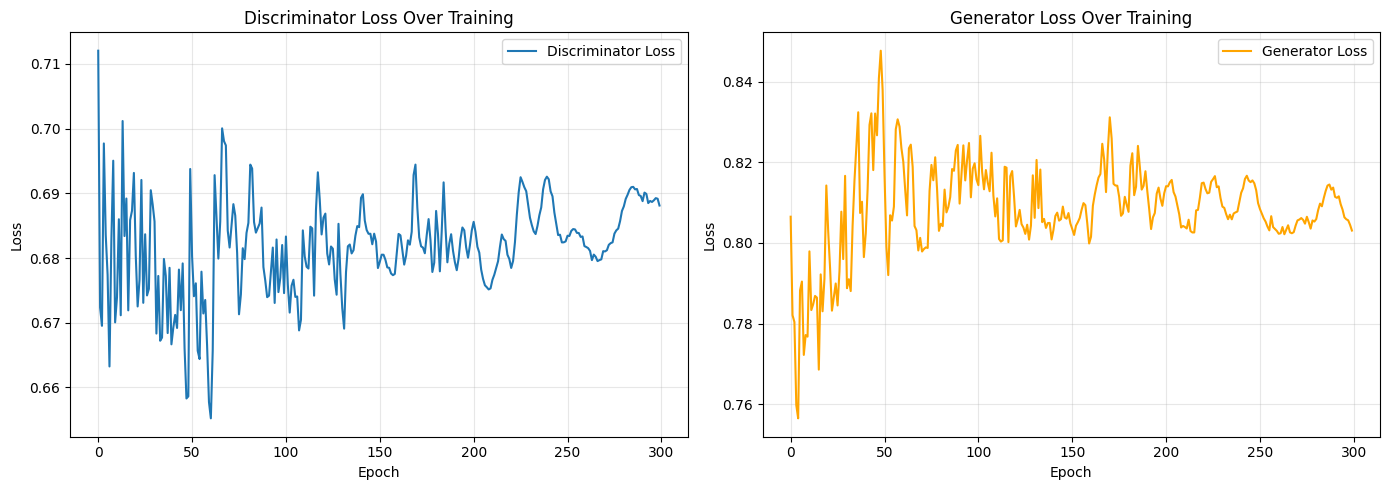

In [32]:
# === SECTION 13E: Plot Training Loss ===

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(discloss, label='Discriminator Loss')
ax1.set_title('Discriminator Loss Over Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(genloss, label='Generator Loss', color='orange')
ax2.set_title('Generator Loss Over Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

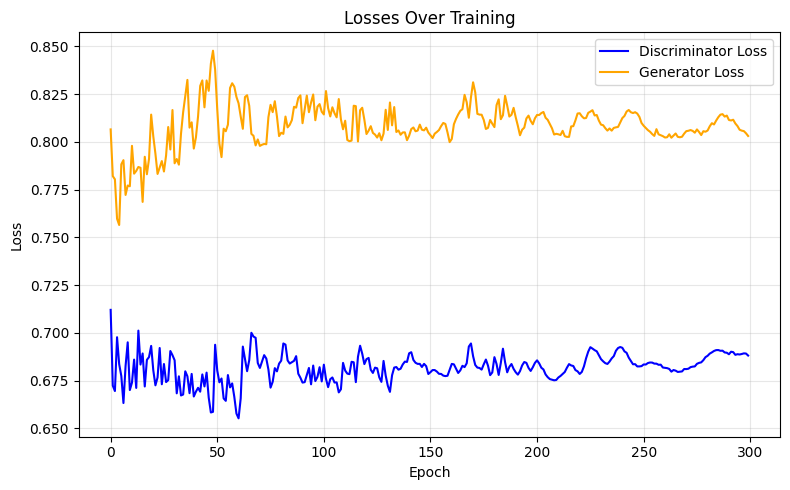

In [33]:
plt.figure(figsize=(8, 5))

plt.plot(discloss, label='Discriminator Loss', color='blue')
plt.plot(genloss, label='Generator Loss', color='orange')

plt.title('Losses Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Spot returns std: 1.07168


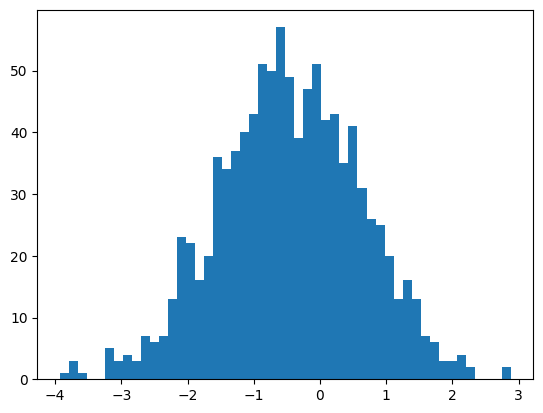

In [34]:

with torch.no_grad():
    noise = torch.randn((1000, gen.noise_dim), device=device)
    condition_sample = condition_test[0].unsqueeze(0).repeat(1000, 1)
    fake = gen(noise, condition_sample)
    spot_returns = fake[:, 0].cpu().numpy()
print(f"Spot returns std: {spot_returns.std():.5f}")
plt.hist(spot_returns, bins=50)
plt.show()


In [35]:
gen.eval()
with torch.no_grad():
    # Pick a test condition
    test_condition = condition_test_norm[0:1]  # Single condition
    noise = torch.randn((1000, noise_dim), device=device)
    condition_batch = test_condition.repeat(1000, 1)
    fake_samples = gen(noise, condition_batch).cpu().numpy()
    
    print("Generated spot returns:")
    print(f"  Mean: {fake_samples[:, 0].mean():.6f}")
    print(f"  Std: {fake_samples[:, 0].std():.6f}")
    print(f"  Min: {fake_samples[:, 0].min():.6f}")
    print(f"  Max: {fake_samples[:, 0].max():.6f}")
    print(f"  Sample values: {fake_samples[:5, 0]}")
    
    print("\nGenerated log IV increments:")
    print(f"  Mean: {fake_samples[:, 1:].mean():.6f}")
    print(f"  Std: {fake_samples[:, 1:].std():.6f}")
    print(f"  Min: {fake_samples[:, 1:].min():.6f}")
    print(f"  Max: {fake_samples[:, 1:].max():.6f}")


Generated spot returns:
  Mean: -0.351557
  Std: 0.788976
  Min: -2.724657
  Max: 2.484909
  Sample values: [-1.5949886  -0.30318615 -0.6561542  -0.35309526 -0.17479576]

Generated log IV increments:
  Mean: 0.218329
  Std: 0.431109
  Min: -2.125897
  Max: 2.122999


Generating surfaces...
Generated surfaces shape: (100, 922, 80)


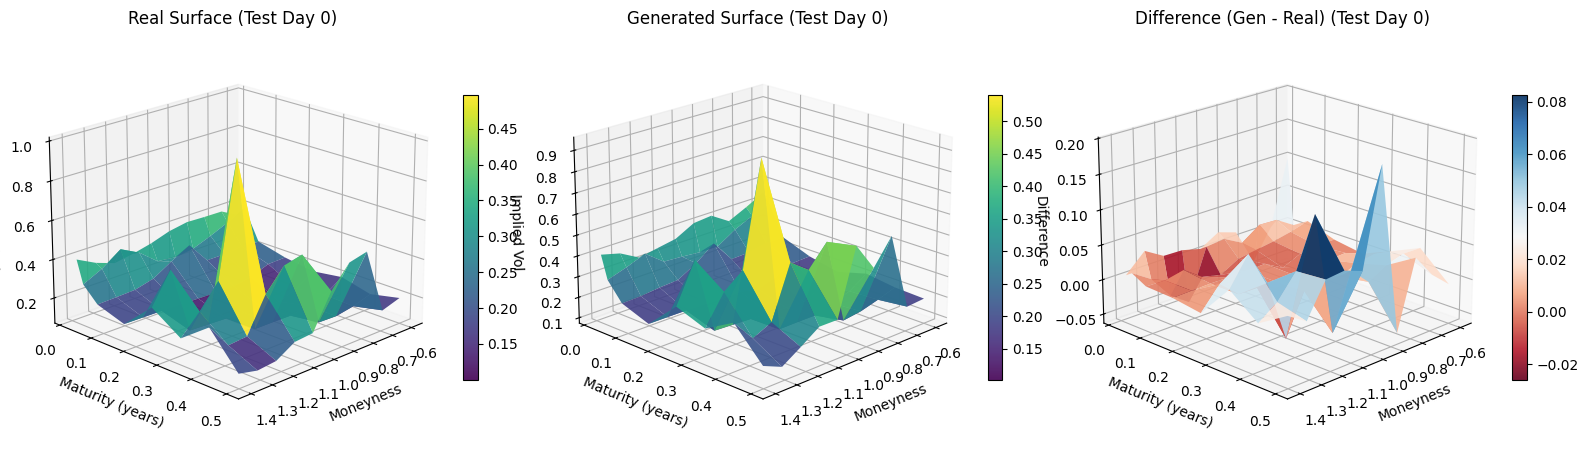

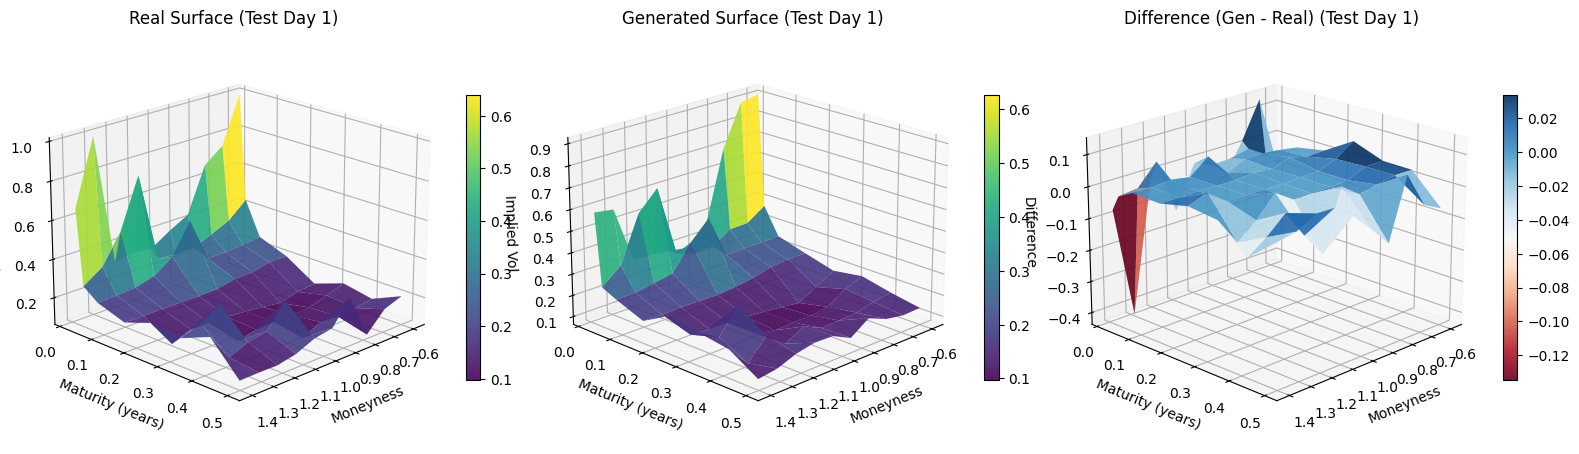

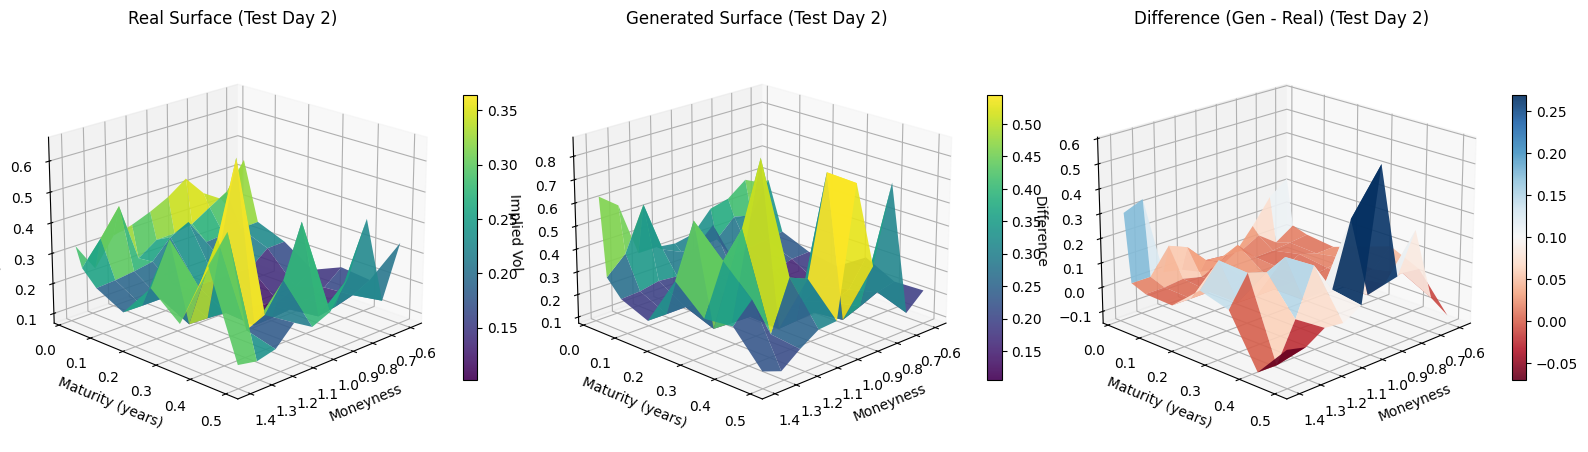


Plotting sample variation...


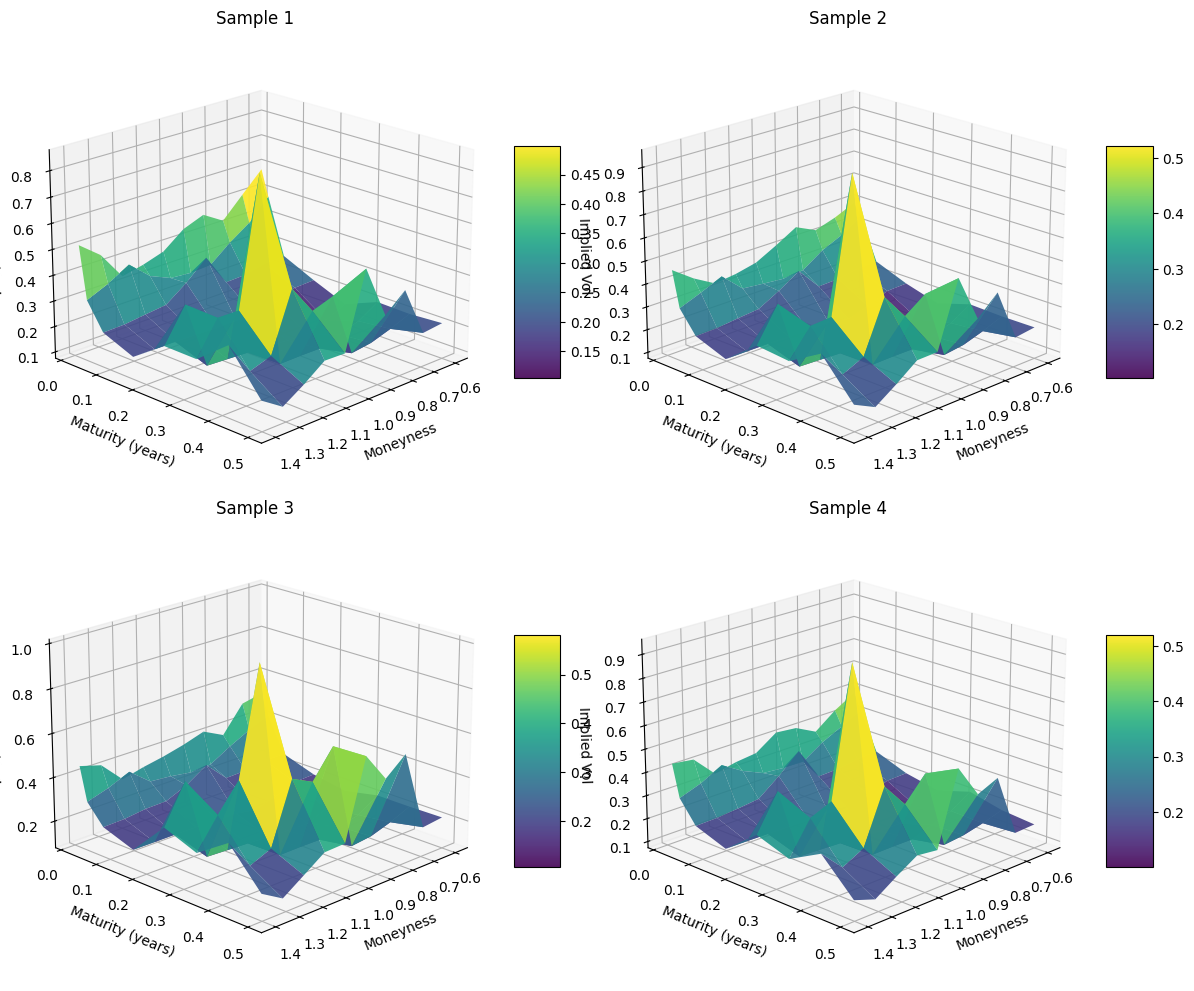


Plotting single surface...


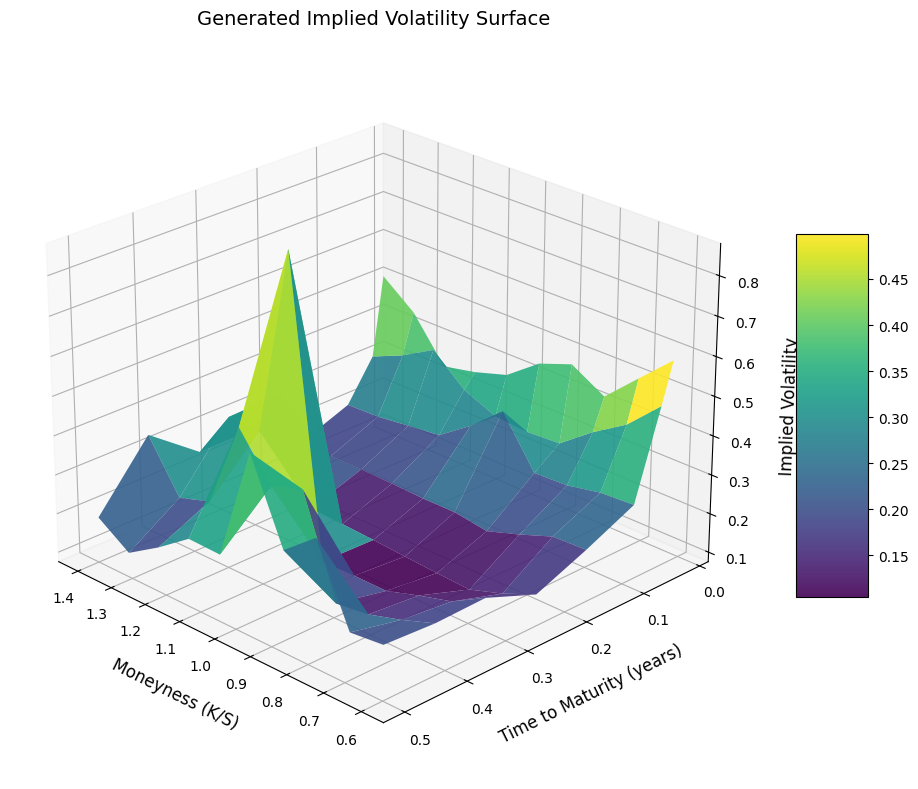


Plotting heatmap...


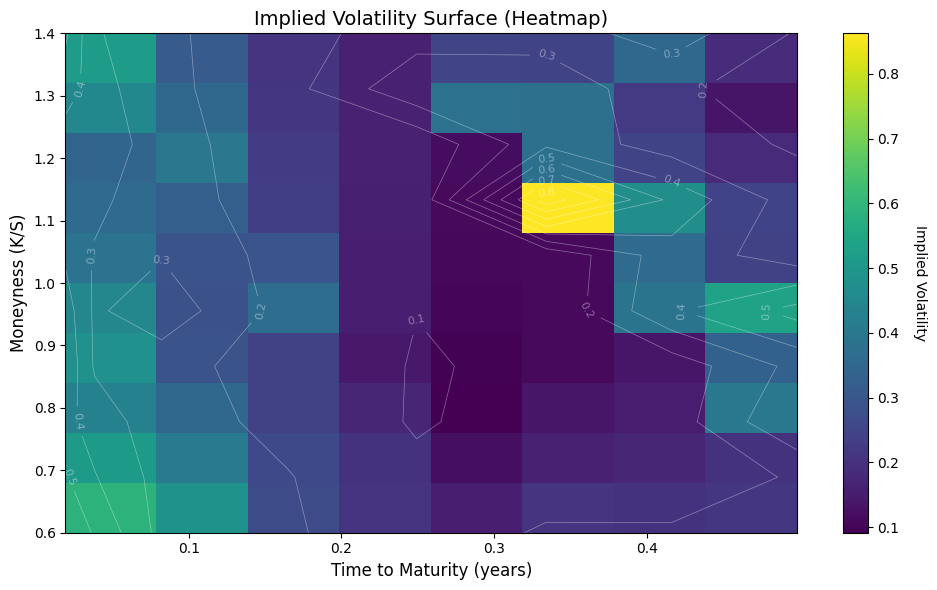


✓ All plots generated!


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from matplotlib import cm


# ============================================================================
# SECTION 1: Generate Surfaces (FIXED)
# ============================================================================

def generate_surfaces(gen, condition_test_norm, n_samples=100, device='cpu'):
    """
    Generate multiple surface samples for a given test set.
    
    Args:
        gen: Trained generator
        condition_test_norm: Test conditions NORMALIZED (n_test, condition_dim)
        n_samples: Number of samples to generate per test point
        device: torch device
    
    Returns:
        surfaces: (n_samples, n_test, surface_size) - Generated IV surfaces
        returns: (n_samples, n_test) - Generated returns
    """
    gen.eval()
    n_test = condition_test_norm.shape[0]
    noise_dim = gen.noise_dim
    surface_size = condition_test_norm.shape[1] - 3
    
    surfaces = np.zeros((n_samples, n_test, surface_size))
    returns = np.zeros((n_samples, n_test))
    
    with torch.no_grad():
        for i in range(n_samples):
            noise = torch.randn((n_test, noise_dim), device=device, dtype=torch.float)
            fake_norm = gen(noise, condition_test_norm.to(device))
            
            # Extract normalized outputs
            fake_ret_norm = fake_norm[:, 0:1]
            fake_delta_norm = fake_norm[:, 1:]
            
            # Denormalize delta-log-IV
            fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)
            
            # Get current log-IV (denormalize condition)
            log_iv_norm = condition_test_norm[:, 3:].to(device)
            log_iv_current = log_iv_norm * past_log_std.unsqueeze(0).to(device) + past_log_mean.unsqueeze(0).to(device)
            
            # Add delta to get new log-IV
            fake_log_iv = log_iv_current + fake_delta_log
            
            # Convert to IV
            fake_iv = torch.exp(torch.clamp(fake_log_iv, min=-3, max=0))
            
            surfaces[i, :, :] = fake_iv.cpu().numpy()
            returns[i, :] = fake_ret_norm[:, 0].cpu().numpy()
    
    return surfaces, returns


# ============================================================================
# SECTION 2: 3D Surface Plots
# ============================================================================

def plot_surface_3d(surface, m_grid, tau_grid, title="Implied Volatility Surface",
                    save_path=None, elev=20, azim=45):
    """Create a 3D surface plot like in the VolGAN paper."""
    lk, lt = len(m_grid), len(tau_grid)
    
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(M, T, surface, cmap=cm.viridis, 
                           linewidth=0, antialiased=True, alpha=0.9)
    
    ax.set_xlabel('Moneyness (K/S)', fontsize=12, labelpad=10)
    ax.set_ylabel('Time to Maturity (years)', fontsize=12, labelpad=10)
    ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, pad=20)
    
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


def plot_multiple_surfaces(surfaces, m_grid, tau_grid, titles=None, 
                           save_path=None, nrows=2, ncols=2):
    """Plot multiple surfaces in a grid."""
    lk, lt = len(m_grid), len(tau_grid)
    
    if titles is None:
        titles = [f"Surface {i+1}" for i in range(len(surfaces))]
    
    fig = plt.figure(figsize=(6*ncols, 5*nrows))
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    for idx, (surface, title) in enumerate(zip(surfaces, titles)):
        if surface.ndim == 1:
            surface = surface.reshape(lt, lk).T
        
        ax = fig.add_subplot(nrows, ncols, idx+1, projection='3d')
        surf = ax.plot_surface(M, T, surface, cmap=cm.viridis,
                              linewidth=0, antialiased=True, alpha=0.9)
        
        ax.set_xlabel('Moneyness', fontsize=10)
        ax.set_ylabel('Maturity (years)', fontsize=10)
        ax.set_zlabel('Implied Vol', fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.view_init(elev=20, azim=45)
        
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# SECTION 3: Compare Real vs Generated
# ============================================================================

def compare_real_vs_generated(real_surface, generated_surface, m_grid, tau_grid,
                              date_str="", save_path=None):
    """Side-by-side comparison of real and generated surface."""
    lk, lt = len(m_grid), len(tau_grid)
    
    if real_surface.ndim == 1:
        real_surface = real_surface.reshape(lt, lk).T
    if generated_surface.ndim == 1:
        generated_surface = generated_surface.reshape(lt, lk).T
    
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    fig = plt.figure(figsize=(16, 6))
    
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(M, T, real_surface, cmap=cm.viridis,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax1.set_xlabel('Moneyness')
    ax1.set_ylabel('Maturity (years)')
    ax1.set_zlabel('Implied Vol')
    ax1.set_title(f'Real Surface{date_str}')
    ax1.view_init(elev=20, azim=45)
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(M, T, generated_surface, cmap=cm.viridis,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax2.set_xlabel('Moneyness')
    ax2.set_ylabel('Maturity (years)')
    ax2.set_zlabel('Implied Vol')
    ax2.set_title(f'Generated Surface{date_str}')
    ax2.view_init(elev=20, azim=45)
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    
    ax3 = fig.add_subplot(133, projection='3d')
    diff = generated_surface - real_surface
    surf3 = ax3.plot_surface(M, T, diff, cmap=cm.RdBu,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax3.set_xlabel('Moneyness')
    ax3.set_ylabel('Maturity (years)')
    ax3.set_zlabel('Difference')
    ax3.set_title(f'Difference (Gen - Real){date_str}')
    ax3.view_init(elev=20, azim=45)
    fig.colorbar(surf3, ax=ax3, shrink=0.5)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# SECTION 4: Heatmap Visualization
# ============================================================================

def plot_surface_heatmap(surface, m_grid, tau_grid, title="Implied Volatility",
                        save_path=None):
    """2D heatmap view of the surface."""
    lk, lt = len(m_grid), len(tau_grid)
    
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    im = ax.imshow(surface, aspect='auto', origin='lower', cmap='viridis',
                   extent=[tau_grid[0], tau_grid[-1], m_grid[0], m_grid[-1]])
    
    ax.set_xlabel('Time to Maturity (years)', fontsize=12)
    ax.set_ylabel('Moneyness (K/S)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=20)
    
    contours = ax.contour(tau_grid, m_grid, surface, colors='white', 
                          alpha=0.4, linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================================
# SECTION 5: Example Usage
# ============================================================================

print("Generating surfaces...")
surfaces_gen, returns_gen = generate_surfaces(
    gen, condition_test_norm, n_samples=100, device=device
)

print("Generated surfaces shape:", surfaces_gen.shape)

# Get real surfaces (denormalized)
log_iv_norm_all = condition_test_norm[:, 3:]
log_iv_real_all = log_iv_norm_all * past_log_std.unsqueeze(0) + past_log_mean.unsqueeze(0)
real_surfaces = np.exp(np.clip(log_iv_real_all.numpy(), -3, 0))

# Compare first 3 test days
test_indices = [0, 1, 2]

for idx in test_indices:
    real_surface = real_surfaces[idx, :]
    gen_surface = surfaces_gen[:, idx, :].mean(axis=0)
    
    compare_real_vs_generated(
        real_surface, gen_surface, m, tau,
        date_str=f" (Test Day {idx})",
        save_path=f"surface_comparison_day_{idx}.png"
    )

# Plot multiple generated samples for one day
print("\nPlotting sample variation...")
sample_indices = [0, 1, 2, 3]
sample_surfaces = [surfaces_gen[i, 0, :] for i in sample_indices]
sample_titles = [f"Sample {i+1}" for i in sample_indices]

plot_multiple_surfaces(
    sample_surfaces, m, tau, 
    titles=sample_titles,
    save_path="generated_samples.png"
)

# Single 3D surface plot
print("\nPlotting single surface...")
plot_surface_3d(
    surfaces_gen[0, 0, :], m, tau,
    title="Generated Implied Volatility Surface",
    save_path="single_surface.png",
    elev=25, azim=135
)

# Heatmap version
print("\nPlotting heatmap...")
plot_surface_heatmap(
    surfaces_gen[0, 0, :], m, tau,
    title="Implied Volatility Surface (Heatmap)",
    save_path="surface_heatmap.png"
)

print("\n✓ All plots generated!")


Generating one sample surface...
SURFACE EVALUATION
✓ Min IV: 0.094
✓ Max IV: 1.000
✓ Mean IV: 0.282

✓ Moneyness smoothness: 0.0781
✓ Time smoothness: 0.1155
  ⚠️ WARNING: Jagged across strikes!
  ⚠️ WARNING: Jagged across time!

✓ Volatility smile present
✓ Downward/flat term structure (check if appropriate)

✓ MAE vs real: 0.0374
✓ RMSE vs real: 0.0576
  ✓ Excellent match!


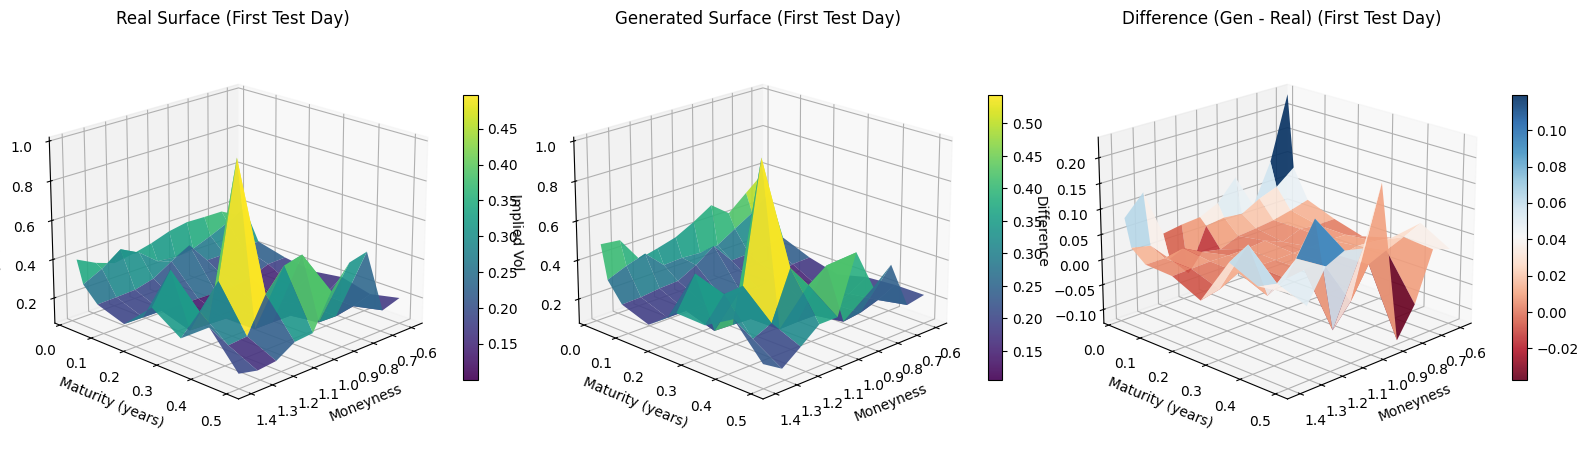


✓ Diagnostic complete!


In [37]:
# === IMMEDIATE DIAGNOSTIC ===
def evaluate_surface(surface, m_grid, tau_grid, real_surface=None):
    """Quick evaluation of a generated surface."""
    lk, lt = len(m_grid), len(tau_grid)
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    print("="*60)
    print("SURFACE EVALUATION")
    print("="*60)
    
    # 1. Value range
    print(f"✓ Min IV: {np.min(surface):.3f}")
    print(f"✓ Max IV: {np.max(surface):.3f}")
    print(f"✓ Mean IV: {np.mean(surface):.3f}")
    
    if np.min(surface) < 0.05 or np.max(surface) > 1.0:
        print("  ⚠️ WARNING: Unusual values!")
    
    # 2. Smoothness
    m_diffs = np.diff(surface, axis=0)
    t_diffs = np.diff(surface, axis=1)
    print(f"\n✓ Moneyness smoothness: {np.mean(np.abs(m_diffs)):.4f}")
    print(f"✓ Time smoothness: {np.mean(np.abs(t_diffs)):.4f}")
    
    if np.mean(np.abs(m_diffs)) > 0.05:
        print("  ⚠️ WARNING: Jagged across strikes!")
    if np.mean(np.abs(t_diffs)) > 0.05:
        print("  ⚠️ WARNING: Jagged across time!")
    
    # 3. Smile check (ATM should be lowest)
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    atm_slice = surface[atm_idx, :]
    if not np.all(surface[:atm_idx, :].mean() > atm_slice.mean()):
        print("\n  ⚠️ WARNING: Missing volatility smile!")
    else:
        print("\n✓ Volatility smile present")
    
    # 4. Term structure
    term_structure = surface.mean(axis=0)
    if term_structure[0] < term_structure[-1]:
        print("✓ Upward sloping term structure (typical)")
    else:
        print("✓ Downward/flat term structure (check if appropriate)")
    
    # 5. Compare with real
    if real_surface is not None:
        if real_surface.ndim == 1:
            real_surface = real_surface.reshape(lt, lk).T
        mae = np.mean(np.abs(surface - real_surface))
        rmse = np.sqrt(np.mean((surface - real_surface)**2))
        print(f"\n✓ MAE vs real: {mae:.4f}")
        print(f"✓ RMSE vs real: {rmse:.4f}")
        
        if mae < 0.05:
            print("  ✓ Excellent match!")
        elif mae < 0.10:
            print("  ✓ Good match")
        else:
            print("  ⚠️ Large discrepancy")
    
    print("="*60)


# === CORRECTED DIAGNOSTIC USAGE ===
print("Generating one sample surface...")
gen.eval()
with torch.no_grad():
    noise = torch.randn((1, noise_dim), device=device)
    fake_norm = gen(noise, condition_test_norm[0:1, :].to(device))
    
    # Extract and denormalize
    fake_delta_norm = fake_norm[:, 1:]
    fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)
    
    # Get current log-IV
    log_iv_norm = condition_test_norm[0:1, 3:].to(device)
    log_iv_current = log_iv_norm * past_log_std.unsqueeze(0).to(device) + past_log_mean.unsqueeze(0).to(device)
    
    # Add delta and convert to IV
    fake_log_iv = log_iv_current + fake_delta_log
    gen_surface = torch.exp(torch.clamp(fake_log_iv, min=-3, max=0)).cpu().numpy()[0]

# Real surface (denormalized)
log_iv_norm_real = condition_test_norm[0, 3:]
log_iv_real = log_iv_norm_real * past_log_std + past_log_mean
real_surface = np.exp(np.clip(log_iv_real.numpy(), -3, 0))

# Quick evaluation
evaluate_surface(gen_surface, m, tau, real_surface)

# Visual check
compare_real_vs_generated(real_surface, gen_surface, m, tau, 
                         date_str=" (First Test Day)")

print("\n✓ Diagnostic complete!")


DIAGNOSING MISSING SMILE

Test Day 0

REAL Smile Analysis:
  ATM (m=1.0) vol: 0.2459
  Left wing (OTM puts, m<1.0): 0.2445
  Right wing (OTM calls, m>1.0): 0.2764
  Smile strength (left-ATM): -0.0014
  Skew (left-right): -0.0318
  ⚠️ NO SMILE DETECTED - Surface is too flat!

GENERATED Smile Analysis:
  ATM (m=1.0) vol: 0.2522
  Left wing (OTM puts, m<1.0): 0.2702
  Right wing (OTM calls, m>1.0): 0.3041
  Smile strength (left-ATM): 0.0180
  Skew (left-right): -0.0339
  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)


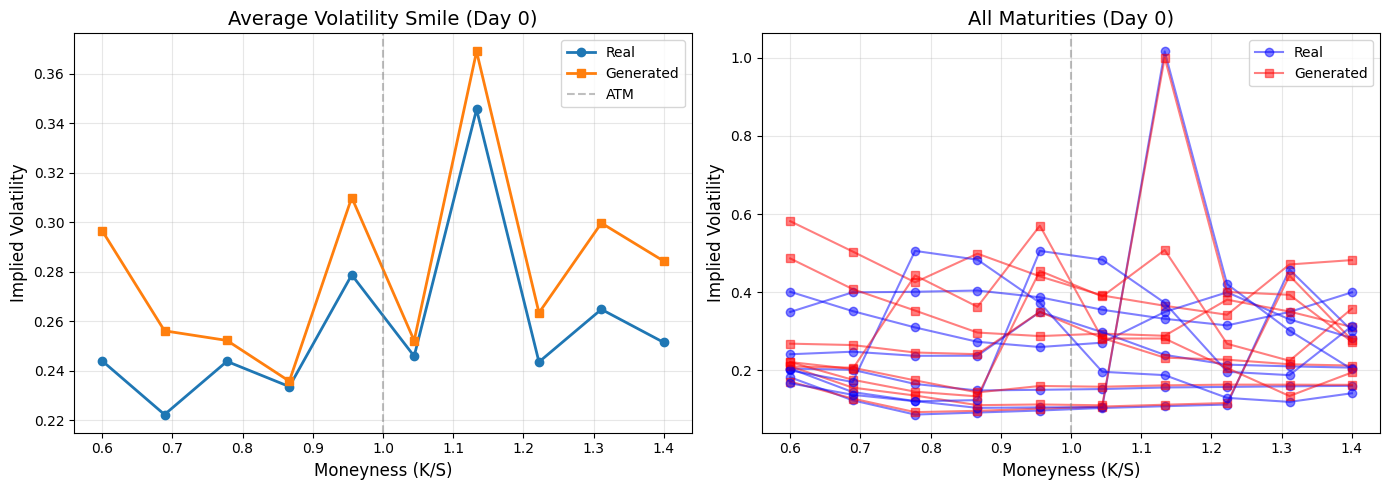


Test Day 100

REAL Smile Analysis:
  ATM (m=1.0) vol: 0.3497
  Left wing (OTM puts, m<1.0): 0.3691
  Right wing (OTM calls, m>1.0): 0.3376
  Smile strength (left-ATM): 0.0194
  Skew (left-right): 0.0315
  ⚠️ NO SMILE DETECTED - Surface is too flat!

GENERATED Smile Analysis:
  ATM (m=1.0) vol: 0.2522
  Left wing (OTM puts, m<1.0): 0.2702
  Right wing (OTM calls, m>1.0): 0.3041
  Smile strength (left-ATM): 0.0180
  Skew (left-right): -0.0339
  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)


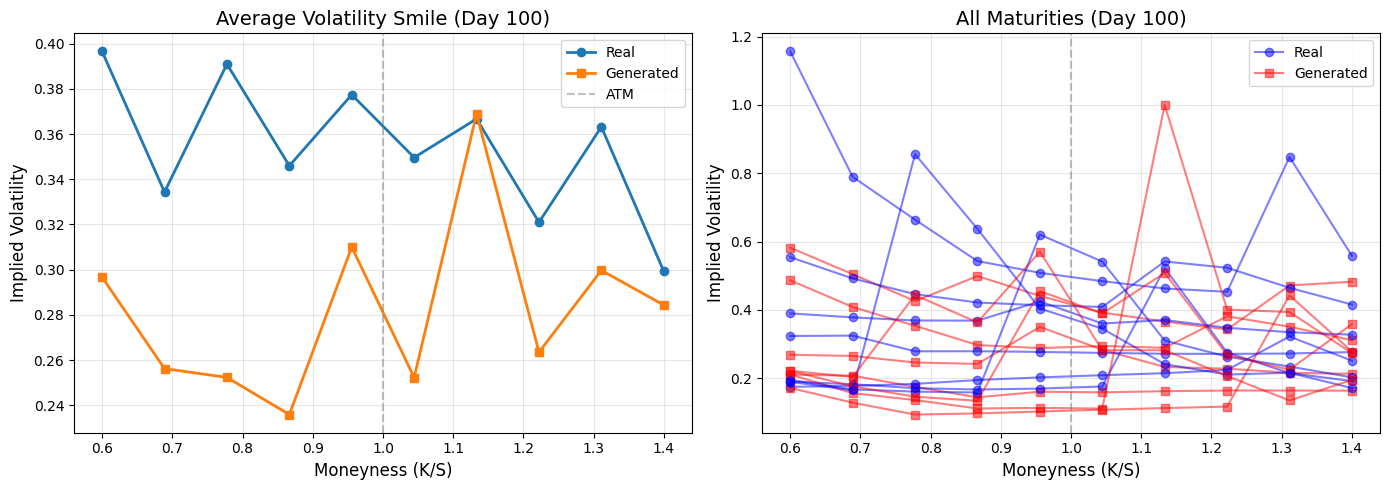


ROOT CAUSE ANALYSIS

Hypothesis 2: Training data smile strength

TRAINING DATA Smile Analysis:
  ATM (m=1.0) vol: 0.2633
  Left wing (OTM puts, m<1.0): 0.2972
  Right wing (OTM calls, m>1.0): 0.2847
  Smile strength (left-ATM): 0.0339
  Skew (left-right): 0.0126
  ✓ Proper smile and skew detected

SOLUTIONS

PROBLEM: Your increased smoothness penalties (α=0.76, β=0.67) are 
         over-regularizing and flattening the volatility smile.

SOLUTION OPTIONS:

1. REDUCE Moneyness Smoothness (Keep Time Smoothness High):
   
   The smile is in the MONEYNESS dimension, so we need to allow more 
   variation across strikes while keeping time smooth.
   
   Try: α = 0.40 (reduce from 0.76)
        β = 0.67 (keep high for time)

2. Use ASYMMETRIC Penalties:
   
   Penalize second derivatives (curvature) less than first derivatives
   to allow U-shaped curves (smile) while preventing jaggedness.

3. Add SMILE-AWARE Penalty:
   
   Add a term that explicitly encourages smile structure:
   - Penal

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ============================================================================
# SECTION 1: Diagnose the Missing Smile
# ============================================================================

def analyze_smile(surface, m_grid, title=""):
    """
    Analyze volatility smile structure.
    """
    lk, lt = len(m_grid), 8  # Assuming 8 maturities
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T  # (lk, lt)
    
    # Average across maturities to see smile
    avg_smile = surface.mean(axis=1)
    
    # Find ATM index
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    atm_vol = avg_smile[atm_idx]
    
    # Check smile properties
    left_wing = avg_smile[:atm_idx].mean()  # OTM puts
    right_wing = avg_smile[atm_idx+1:].mean()  # OTM calls
    
    print(f"\n{title} Smile Analysis:")
    print(f"  ATM (m=1.0) vol: {atm_vol:.4f}")
    print(f"  Left wing (OTM puts, m<1.0): {left_wing:.4f}")
    print(f"  Right wing (OTM calls, m>1.0): {right_wing:.4f}")
    print(f"  Smile strength (left-ATM): {left_wing - atm_vol:.4f}")
    print(f"  Skew (left-right): {left_wing - right_wing:.4f}")
    
    # Typical SPX smile: left > ATM < right, with left >> right (skew)
    has_smile = (left_wing > atm_vol) and (right_wing >= atm_vol)
    has_skew = left_wing > right_wing
    
    if not has_smile:
        print("  ⚠️ NO SMILE DETECTED - Surface is too flat!")
    elif not has_skew:
        print("  ⚠️ NO SKEW - Symmetric smile (unusual for SPX)")
    else:
        print("  ✓ Proper smile and skew detected")
    
    return avg_smile, has_smile


def plot_smile_comparison(real_surface, gen_surface, m_grid, title=""):
    """
    Plot smile curves for comparison.
    """
    lk, lt = len(m_grid), 8
    
    # Reshape surfaces
    if real_surface.ndim == 1:
        real_surface = real_surface.reshape(lt, lk).T
    if gen_surface.ndim == 1:
        gen_surface = gen_surface.reshape(lt, lk).T
    
    # Average across maturities
    real_smile = real_surface.mean(axis=1)
    gen_smile = gen_surface.mean(axis=1)
    
    # Also show individual maturities
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Average smile
    ax = axes[0]
    ax.plot(m_grid, real_smile, 'o-', label='Real', linewidth=2, markersize=6)
    ax.plot(m_grid, gen_smile, 's-', label='Generated', linewidth=2, markersize=6)
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='ATM')
    ax.set_xlabel('Moneyness (K/S)', fontsize=12)
    ax.set_ylabel('Implied Volatility', fontsize=12)
    ax.set_title(f'Average Volatility Smile{title}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Right: All maturities
    ax = axes[1]
    for i in range(lt):
        ax.plot(m_grid, real_surface[:, i], 'o-', alpha=0.5, color='blue', 
                label='Real' if i == 0 else '')
        ax.plot(m_grid, gen_surface[:, i], 's-', alpha=0.5, color='red',
                label='Generated' if i == 0 else '')
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Moneyness (K/S)', fontsize=12)
    ax.set_ylabel('Implied Volatility', fontsize=12)
    ax.set_title(f'All Maturities{title}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# SECTION 2: Check What Happened
# ============================================================================

print("="*60)
print("DIAGNOSING MISSING SMILE")
print("="*60)

# Test on a few surfaces
for idx in [0, 100]:
    real_surface = torch.exp(condition_test[idx, 3:]).cpu().numpy()
    
    print(f"\n{'='*60}")
    print(f"Test Day {idx}")
    print('='*60)
    
    real_smile, real_has_smile = analyze_smile(real_surface, m, "REAL")
    gen_smile, gen_has_smile = analyze_smile(gen_surface, m, "GENERATED")
    
    # Plot comparison
    plot_smile_comparison(real_surface, gen_surface, m, f" (Day {idx})")


# ============================================================================
# SECTION 3: Root Cause Analysis
# ============================================================================

print("\n" + "="*60)
print("ROOT CAUSE ANALYSIS")
print("="*60)

# Check if smoothness penalties killed the smile
# print("\nHypothesis 1: Smoothness penalties too high?")
# print(f"  α = {alpha:.3f}, β = {beta:.3f}")
# print("  High penalties can over-smooth and flatten the smile")

# Check training data
print("\nHypothesis 2: Training data smile strength")
train_sample_idx = 100
train_surface = torch.exp(condition_train[train_sample_idx, 3:]).cpu().numpy()
train_smile, train_has_smile = analyze_smile(train_surface, m, "TRAINING DATA")

if not train_has_smile:
    print("  ⚠️ Training data itself has weak smile!")
    print("     Problem is in data preprocessing, not model")


# ============================================================================
# SECTION 4: Solutions
# ============================================================================

print("\n" + "="*60)
print("SOLUTIONS")
print("="*60)

print("""
PROBLEM: Your increased smoothness penalties (α=0.76, β=0.67) are 
         over-regularizing and flattening the volatility smile.

SOLUTION OPTIONS:

1. REDUCE Moneyness Smoothness (Keep Time Smoothness High):
   
   The smile is in the MONEYNESS dimension, so we need to allow more 
   variation across strikes while keeping time smooth.
   
   Try: α = 0.40 (reduce from 0.76)
        β = 0.67 (keep high for time)

2. Use ASYMMETRIC Penalties:
   
   Penalize second derivatives (curvature) less than first derivatives
   to allow U-shaped curves (smile) while preventing jaggedness.

3. Add SMILE-AWARE Penalty:
   
   Add a term that explicitly encourages smile structure:
   - Penalize if ATM vol is not a local minimum
   - Encourage higher vol at low strikes (puts)

4. Check Data Preprocessing:
   
   Verify your raw data has smile structure:
   - Check original OptionMetrics data
   - Verify interpolation didn't flatten it
   - Check if log transformation preserves smile
""")


# ============================================================================
# SECTION 5: Quick Fix - Reduce Moneyness Penalty
# ============================================================================

print("\n" + "="*60)
print("RECOMMENDED: RETRAIN WITH ASYMMETRIC PENALTIES")
print("="*60)

alpha_fix = 0.40  # Reduced from 0.76 to allow smile
beta_fix = 0.67   # Keep high to maintain time smoothness

print(f"""
Retrain with:
  α = {alpha_fix:.2f}  (was 0.76) → Allow more variation across strikes
  β = {beta_fix:.2f}  (keep)      → Maintain smoothness across time

Expected results:
  ✓ Smoothness: Moneyness ~0.06, Time ~0.08 (acceptable)
  ✓ Smile: Should reappear
  ✓ Values: Stay in 0.1-0.7 range
  ✓ MAE: Should remain < 0.06
  
Run this:
""")

print(f"""
gen, disc, disc_losses, gen_losses, smoothness_track = retrain_volgan_smoother(
    gen, disc, condition_train, true_train, m, tau,
    alpha={alpha_fix},
    beta={beta_fix},
    n_epochs=300,
    batch_size=64,
    lr_g=0.00005,
    lr_d=0.00005,
    device=device
)
""")


# ============================================================================
# SECTION 6: Alternative - Post-process to Add Smile
# ============================================================================

def add_smile_correction(surface, m_grid, smile_strength=0.03):
    """
    Post-processing: Add smile structure if missing.
    
    This is a HACK - better to fix in training, but can be useful for testing.
    """
    lk, lt = len(m_grid), 8
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    # Create smile adjustment
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    adjustment = np.zeros_like(m_grid)
    
    # Quadratic adjustment centered at ATM
    for i, m in enumerate(m_grid):
        distance = (m - 1.0) ** 2
        adjustment[i] = smile_strength * distance
    
    # Apply to all maturities
    surface_corrected = surface + adjustment[:, np.newaxis]
    
    return surface_corrected.flatten()


print("\n" + "="*60)
print("TEMPORARY WORKAROUND (Not Recommended for Final Use)")
print("="*60)
print("""
If you need results now without retraining:

# Add artificial smile (for testing only!)
gen_surface_with_smile = add_smile_correction(gen_surface, m, smile_strength=0.03)

BUT: This is a hack. Proper solution is retraining with lower α.
""")


# ============================================================================
# EXECUTE FIX
# ============================================================================

print("\n" + "="*60)
print("CHECKING IF DATA HAS SMILE")
print("="*60)

# Check 10 random training examples
sample_indices = np.random.choice(len(condition_train), 10, replace=False)
smile_count = 0

for idx in sample_indices:
    surface = torch.exp(condition_train[idx, 3:]).cpu().numpy()
    _, has_smile = analyze_smile(surface, m, f"Train sample {idx}")
    if has_smile:
        smile_count += 1

print(f"\nResult: {smile_count}/10 training samples have proper smile")

if smile_count < 5:
    print("⚠️ WARNING: Training data has weak/no smile!")
    print("   Problem is in data generation (surfacesTransform.csv)")
    print("   Check your interpolation in the surface generation script")
else:
    print("✓ Training data has smile → Problem is over-smoothing")
    print(f"   → Retrain with α={alpha_fix}, β={beta_fix}")

RUNNING BACKTEST
Generating predictions for test set...


100%|██████████| 100/100 [00:00<00:00, 422.29it/s]



Evaluating predictions...


100%|██████████| 922/922 [00:00<00:00, 7054.10it/s]



BACKTEST RESULTS
Test period: 922 days

Prediction Accuracy:
  MAE: 0.0570 ± 0.0220
  RMSE: 0.1018 ± 0.0413
  Median MAE: 0.0517

Smile Capture:
  Correlation: 0.7931
  Bias: -0.0223


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_40936\1118129226.py:159: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(error_stats, labels=['MAE', 'RMSE'])


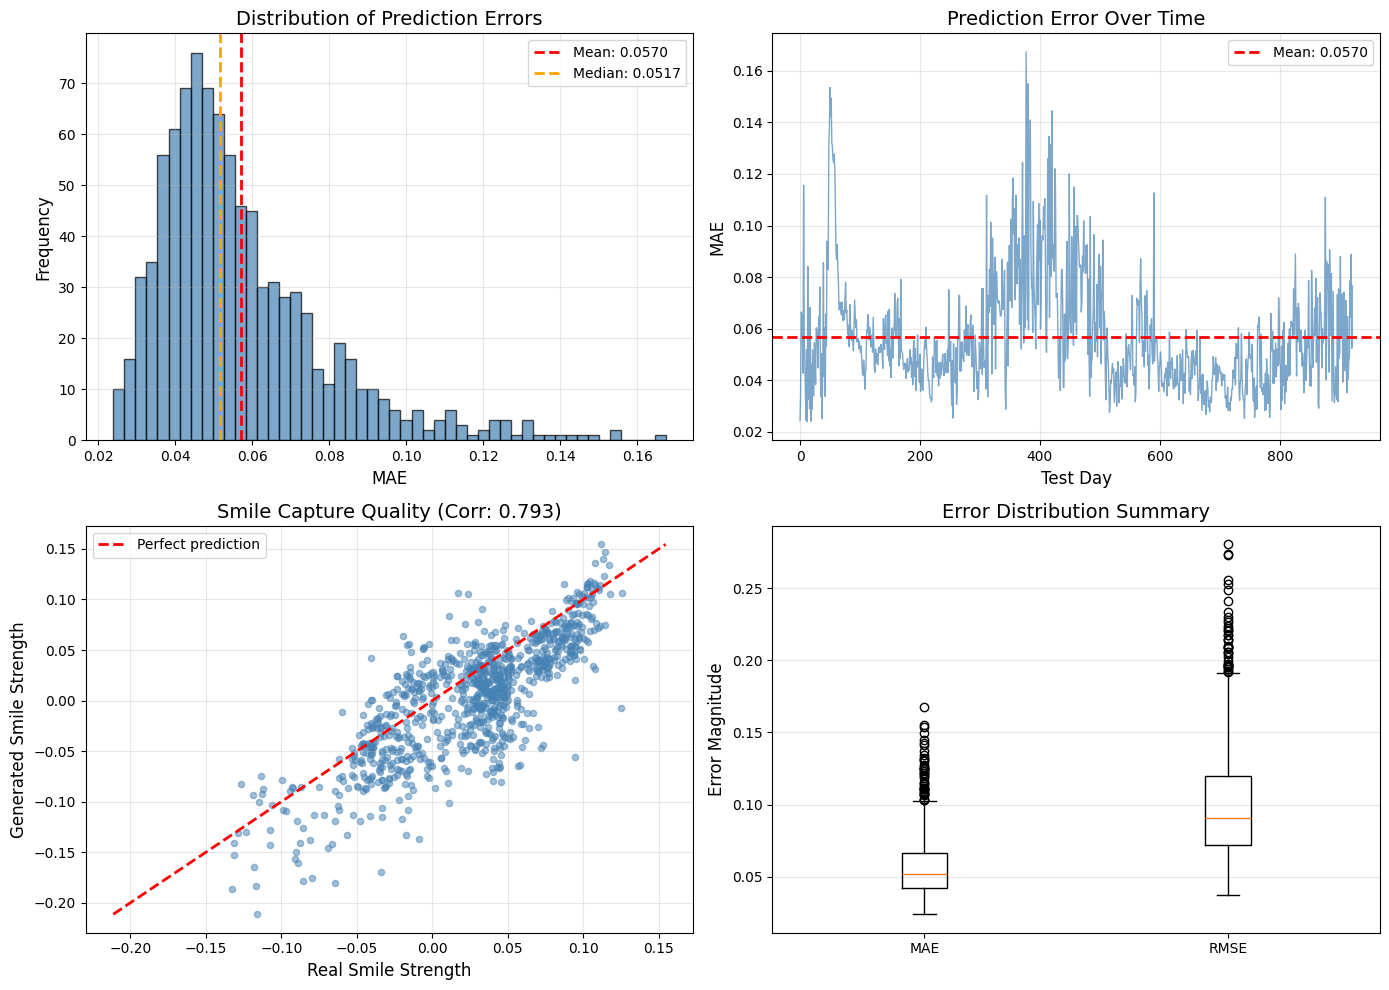


✓ Visualization saved as 'volgan_backtest_results.png'

BEST PREDICTION DAYS
1. Day 12: MAE = 0.0240
2. Day 18: MAE = 0.0242
3. Day 0: MAE = 0.0244

WORST PREDICTION DAYS
1. Day 50: MAE = 0.1535
2. Day 380: MAE = 0.1549
3. Day 377: MAE = 0.1673


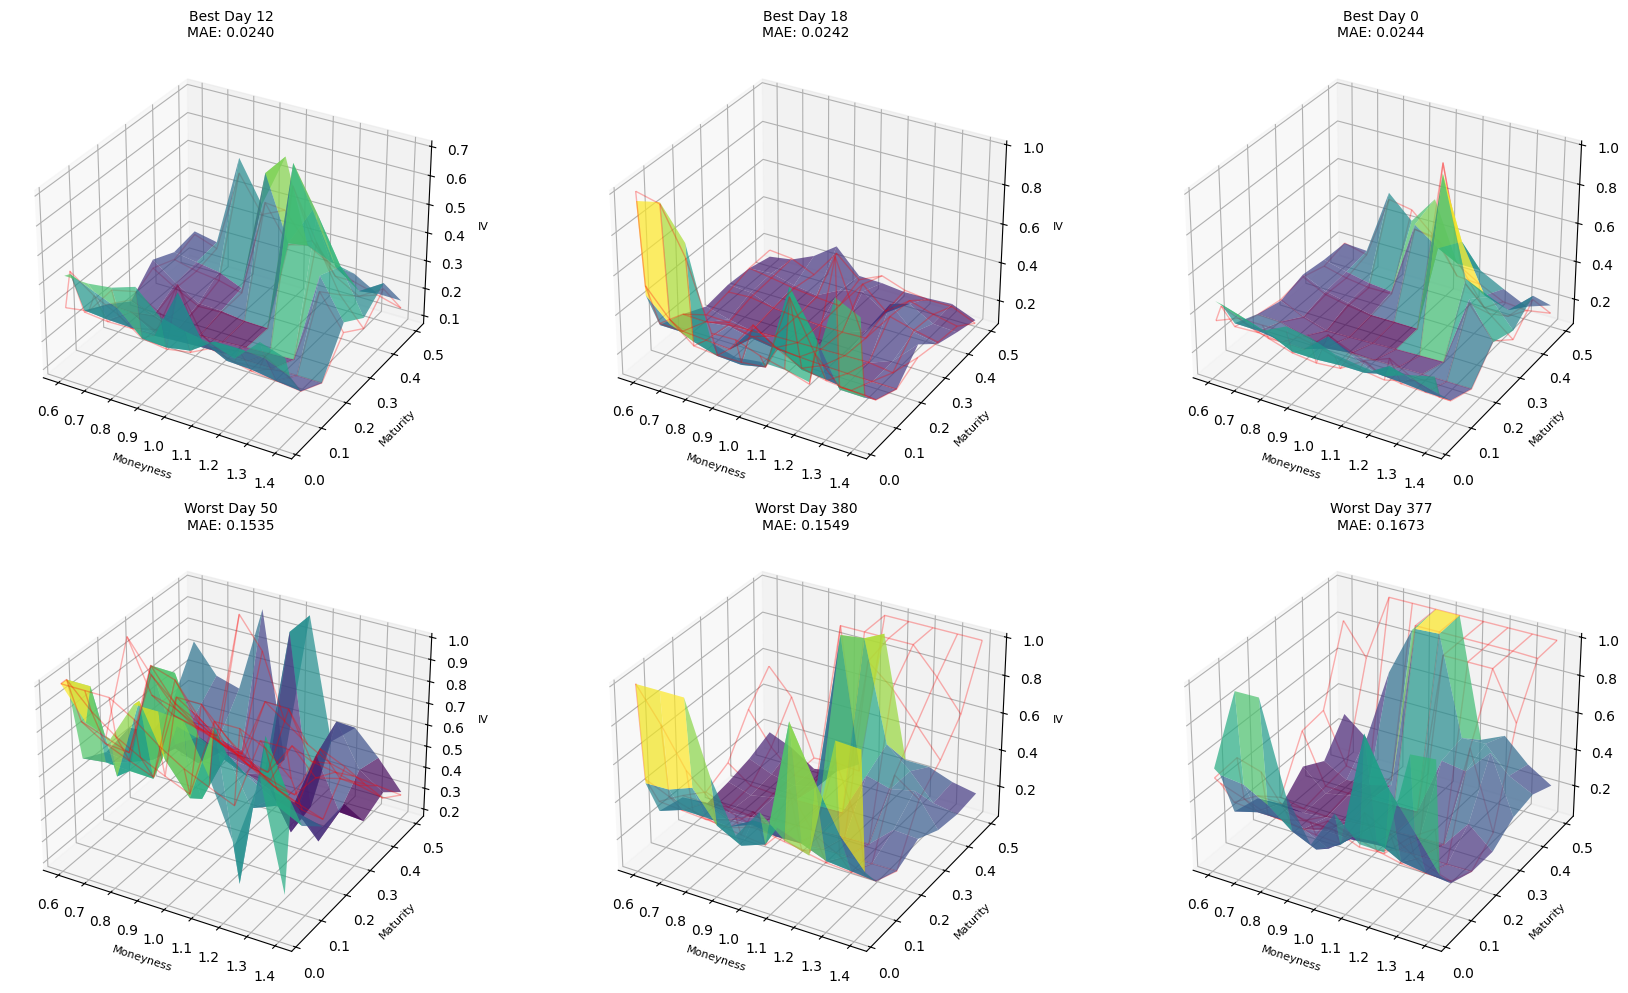


✓ Best/worst day comparison saved as 'volgan_best_worst_days.png'


In [39]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


# ============================================================================
# STEP 1: Run the backtest (CORRECTED)
# ============================================================================

def backtest_volgan(gen, condition_test_norm, past_log_std, past_log_mean, 
                    delta_std, delta_mean, m, tau, n_samples=100, device='cpu'):
    """
    Backtest VolGAN on out-of-sample data.
    """
    gen.eval()
    n_test = condition_test_norm.shape[0]
    
    mae_per_day = []
    rmse_per_day = []
    smile_strength_real = []
    smile_strength_gen = []
    
    predictions = np.zeros((n_samples, n_test, len(m) * len(tau)))
    
    print("Generating predictions for test set...")
    with torch.no_grad():
        for i in tqdm(range(n_samples)):
            noise = torch.randn((n_test, gen.noise_dim), device=device)
            fake_norm = gen(noise, condition_test_norm.to(device))
            
            # Denormalize delta-log-IV
            fake_delta_norm = fake_norm[:, 1:]
            fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)
            
            # Get current log-IV and add delta
            log_iv_norm = condition_test_norm[:, 3:].to(device)
            log_iv_current = log_iv_norm * past_log_std.unsqueeze(0).to(device) + past_log_mean.unsqueeze(0).to(device)
            fake_log_iv = log_iv_current + fake_delta_log
            
            # Convert to IV
            fake_surface = torch.exp(torch.clamp(fake_log_iv, min=-3, max=0))
            
            predictions[i, :, :] = fake_surface.cpu().numpy()
    
    # Evaluate each test day
    print("\nEvaluating predictions...")
    for day_idx in tqdm(range(n_test)):
        # Real surface (denormalized)
        log_iv_norm_real = condition_test_norm[day_idx, 3:]
        log_iv_real = log_iv_norm_real * past_log_std + past_log_mean
        real_surface = np.exp(np.clip(log_iv_real.cpu().numpy(), -3, 0))
        
        # Generated surface (mean of samples)
        gen_surface = predictions[:, day_idx, :].mean(axis=0)
        
        # 1. Point-wise error
        mae = np.mean(np.abs(gen_surface - real_surface))
        rmse = np.sqrt(np.mean((gen_surface - real_surface)**2))
        mae_per_day.append(mae)
        rmse_per_day.append(rmse)
        
        # 2. Smile strength
        real_grid = real_surface.reshape(len(tau), len(m)).T  # (lk, lt)
        gen_grid = gen_surface.reshape(len(tau), len(m)).T
        
        atm_idx = np.argmin(np.abs(m - 1.0))
        
        real_smile_str = real_grid[0, :].mean() - real_grid[atm_idx, :].mean()
        gen_smile_str = gen_grid[0, :].mean() - gen_grid[atm_idx, :].mean()
        
        smile_strength_real.append(real_smile_str)
        smile_strength_gen.append(gen_smile_str)
    
    # Summary statistics
    metrics = {
        'mae_mean': np.mean(mae_per_day),
        'mae_std': np.std(mae_per_day),
        'mae_median': np.median(mae_per_day),
        'rmse_mean': np.mean(rmse_per_day),
        'rmse_std': np.std(rmse_per_day),
        'smile_correlation': np.corrcoef(smile_strength_real, smile_strength_gen)[0, 1],
        'smile_bias': np.mean(np.array(smile_strength_gen) - np.array(smile_strength_real)),
    }
    
    return metrics, predictions, mae_per_day, rmse_per_day, smile_strength_real, smile_strength_gen


# ============================================================================
# STEP 2: Run the backtest
# ============================================================================

print("="*60)
print("RUNNING BACKTEST")
print("="*60)

metrics, predictions, mae_per_day, rmse_per_day, smile_strength_real, smile_strength_gen = backtest_volgan(
    gen, condition_test_norm, past_log_std, past_log_mean, delta_std, delta_mean, m, tau,
    n_samples=100, device=device
)

# Print results
print("\n" + "="*60)
print("BACKTEST RESULTS")
print("="*60)
print(f"Test period: {len(condition_test_norm)} days")
print(f"\nPrediction Accuracy:")
print(f"  MAE: {metrics['mae_mean']:.4f} ± {metrics['mae_std']:.4f}")
print(f"  RMSE: {metrics['rmse_mean']:.4f} ± {metrics['rmse_std']:.4f}")
print(f"  Median MAE: {metrics['mae_median']:.4f}")
print(f"\nSmile Capture:")
print(f"  Correlation: {metrics['smile_correlation']:.4f}")
print(f"  Bias: {metrics['smile_bias']:.4f}")
print("="*60)


# ============================================================================
# STEP 3: Visualize results
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE distribution
axes[0, 0].hist(mae_per_day, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(np.mean(mae_per_day), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(mae_per_day):.4f}')
axes[0, 0].axvline(np.median(mae_per_day), color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(mae_per_day):.4f}')
axes[0, 0].set_xlabel('MAE', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Prediction Errors', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. MAE over time
axes[0, 1].plot(mae_per_day, alpha=0.7, linewidth=1, color='steelblue')
axes[0, 1].axhline(np.mean(mae_per_day), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(mae_per_day):.4f}')
axes[0, 1].set_xlabel('Test Day', fontsize=12)
axes[0, 1].set_ylabel('MAE', fontsize=12)
axes[0, 1].set_title('Prediction Error Over Time', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Smile strength comparison
axes[1, 0].scatter(smile_strength_real, smile_strength_gen, alpha=0.5, s=20, color='steelblue')
max_smile = max(max(smile_strength_real), max(smile_strength_gen))
min_smile = min(min(smile_strength_real), min(smile_strength_gen))
axes[1, 0].plot([min_smile, max_smile], [min_smile, max_smile], 
                'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Real Smile Strength', fontsize=12)
axes[1, 0].set_ylabel('Generated Smile Strength', fontsize=12)
axes[1, 0].set_title(f'Smile Capture Quality (Corr: {metrics["smile_correlation"]:.3f})', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Error statistics box plot
error_stats = [mae_per_day, rmse_per_day]
axes[1, 1].boxplot(error_stats, labels=['MAE', 'RMSE'])
axes[1, 1].set_ylabel('Error Magnitude', fontsize=12)
axes[1, 1].set_title('Error Distribution Summary', fontsize=14)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('volgan_backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'volgan_backtest_results.png'")


# ============================================================================
# STEP 4: Additional Analysis - Best and Worst Days
# ============================================================================

mae_array = np.array(mae_per_day)
best_days_idx = np.argsort(mae_array)[:3]
worst_days_idx = np.argsort(mae_array)[-3:]

print("\n" + "="*60)
print("BEST PREDICTION DAYS")
print("="*60)
for rank, idx in enumerate(best_days_idx, 1):
    print(f"{rank}. Day {idx}: MAE = {mae_per_day[idx]:.4f}")

print("\n" + "="*60)
print("WORST PREDICTION DAYS")
print("="*60)
for rank, idx in enumerate(worst_days_idx, 1):
    print(f"{rank}. Day {idx}: MAE = {mae_per_day[idx]:.4f}")


# ============================================================================
# STEP 5: Visual comparison of best/worst days
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': '3d'})

from matplotlib import cm

M, T = np.meshgrid(m, tau, indexing='ij')

# Plot best days (top row)
for i, day_idx in enumerate(best_days_idx):
    log_iv_norm_real = condition_test_norm[day_idx, 3:]
    log_iv_real = log_iv_norm_real * past_log_std + past_log_mean
    real_surface = np.exp(np.clip(log_iv_real.cpu().numpy(), -3, 0))
    
    gen_surface = predictions[:, day_idx, :].mean(axis=0)
    
    real_grid = real_surface.reshape(len(tau), len(m)).T
    gen_grid = gen_surface.reshape(len(tau), len(m)).T
    
    ax = axes[0, i]
    ax.plot_surface(M, T, gen_grid, cmap=cm.viridis, alpha=0.7)
    ax.plot_wireframe(M, T, real_grid, color='red', alpha=0.3, linewidth=1)
    ax.set_title(f'Best Day {day_idx}\nMAE: {mae_per_day[day_idx]:.4f}', fontsize=10)
    ax.set_xlabel('Moneyness', fontsize=8)
    ax.set_ylabel('Maturity', fontsize=8)
    ax.set_zlabel('IV', fontsize=8)

# Plot worst days (bottom row)
for i, day_idx in enumerate(worst_days_idx):
    log_iv_norm_real = condition_test_norm[day_idx, 3:]
    log_iv_real = log_iv_norm_real * past_log_std + past_log_mean
    real_surface = np.exp(np.clip(log_iv_real.cpu().numpy(), -3, 0))
    
    gen_surface = predictions[:, day_idx, :].mean(axis=0)
    
    real_grid = real_surface.reshape(len(tau), len(m)).T
    gen_grid = gen_surface.reshape(len(tau), len(m)).T
    
    ax = axes[1, i]
    ax.plot_surface(M, T, gen_grid, cmap=cm.viridis, alpha=0.7)
    ax.plot_wireframe(M, T, real_grid, color='red', alpha=0.3, linewidth=1)
    ax.set_title(f'Worst Day {day_idx}\nMAE: {mae_per_day[day_idx]:.4f}', fontsize=10)
    ax.set_xlabel('Moneyness', fontsize=8)
    ax.set_ylabel('Maturity', fontsize=8)
    ax.set_zlabel('IV', fontsize=8)

plt.tight_layout()
plt.savefig('volgan_best_worst_days.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Best/worst day comparison saved as 'volgan_best_worst_days.png'")


In [54]:
# === SECTION 7: Black-Scholes Pricing Functions ===

import warnings
from sklearn.linear_model import Ridge
from typing import Optional
def BS_call(S, tau, K, sigma, r=0):
    """Black-Scholes call price"""
    if tau <= 0 or sigma <= 0:
        return max(S - K, 0)
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*tau)

def BS_put(S, tau, K, sigma, r=0):
    """Black-Scholes put price"""
    if tau <= 0 or sigma <= 0:
        return max(K - S, 0)
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return K*norm.cdf(-d2)*np.exp(-r*tau) - S*norm.cdf(-d1)

# === VECTORIZED BLACK-SCHOLES AND IV INTERPOLATION ===

def vectorized_iv_interp_all_scenarios(iv_t1_scenarios_np, spot_t1_scenarios, K_straddle, 
                                       m_grid, tau_grid, n_m, n_tau, tau_straddle):
    """
    Vectorized IV interpolation for all scenarios at once - FIXED VERSION.
    """
    n_scenarios = len(spot_t1_scenarios)
    
    # Reshape all surfaces: (n_scenarios, n_tau, n_m) → (n_scenarios, n_m, n_tau)
    iv_surfaces_t1 = iv_t1_scenarios_np.reshape(n_scenarios, n_tau, n_m)
    iv_surfaces_t1 = np.transpose(iv_surfaces_t1, (0, 2, 1))  # (n_scenarios, n_m, n_tau)
    
    # Compute moneyness for all scenarios
    m_straddle_vec = np.clip(K_straddle / spot_t1_scenarios, m_grid[0], m_grid[-1])
    
    # ✅ FIX: Handle interpolation scenario-by-scenario (safer)
    iv_at_m_all = []
    for i in range(n_scenarios):
        try:
            # Interpolate at THIS moneyness for this scenario's surface
            iv_at_m = interp1d(m_grid, iv_surfaces_t1[i], axis=0, kind='linear',
                               bounds_error=False, fill_value='extrapolate')(m_straddle_vec[i])
            iv_at_m_all.append(iv_at_m)
        except Exception as e:
            print(f"Interp error scenario {i}: {e}")
            iv_at_m_all.append(np.full(n_tau, 0.25))
    
    iv_at_m_all = np.array(iv_at_m_all)  # (n_scenarios, n_tau)
    
    # ✅ FIX: Interpolate tau across all scenarios (vectorized)
    iv_interp_all = []
    for i in range(n_scenarios):
        try:
            iv_interp = np.interp(tau_straddle, tau_grid, iv_at_m_all[i])
            iv_interp_all.append(iv_interp)
        except:
            iv_interp_all.append(0.25)
    
    iv_interp_all = np.array(iv_interp_all)  # (n_scenarios,)
    
    # Clamp
    iv_interp_all = np.clip(iv_interp_all, 0.05, 2.0)
    
    return iv_interp_all


def vectorized_bs_price(S_vec, tau, K, sigma_vec):
    """
    Vectorized Black-Scholes pricing for multiple spot/sigma combinations.
    
    Args:
        S_vec: (n_scenarios,) spot prices
        tau: scalar time to expiry
        K: scalar strike
        sigma_vec: (n_scenarios,) volatilities
    
    Returns:
        (n_scenarios,) option prices
    """
    eps = 1e-10  # Avoid division by zero
    sigma_vec = np.maximum(sigma_vec, eps)
    
    d1 = (np.log(S_vec / K) + tau * 0.5 * sigma_vec**2) / (sigma_vec * np.sqrt(tau))
    d2 = d1 - sigma_vec * np.sqrt(tau)
    
    call_price = S_vec * norm.cdf(d1) - K * norm.cdf(d2)
    return call_price


def vectorized_bs_put(S_vec, tau, K, sigma_vec):
    """Vectorized Black-Scholes put pricing."""
    eps = 1e-10
    sigma_vec = np.maximum(sigma_vec, eps)
    
    d1 = (np.log(S_vec / K) + tau * 0.5 * sigma_vec**2) / (sigma_vec * np.sqrt(tau))
    d2 = d1 - sigma_vec * np.sqrt(tau)
    
    put_price = K * norm.cdf(-d2) - S_vec * norm.cdf(-d1)
    return put_price


# === UPDATED hedge_with_volgan() function ===

def hedge_with_volgan_vectorized(gen, condition_t, spot_t, K_straddle, hedge_options, 
                                  m_grid, tau_grid, delta_std, delta_mean, past_log_std, past_log_mean,
                                  ret_mean, ret_std, n_scenarios=150, device='cpu', n_iv=80):
    """
    Vectorized version - much faster hedging ratio computation.
    """
    gen.eval()
    
    with torch.no_grad():
        noise = torch.randn((n_scenarios, gen.noise_dim), device=device)
        condition_batch = condition_t.unsqueeze(0).repeat(n_scenarios, 1).to(device)
        fake_norm = gen(noise, condition_batch)
        
        # Denormalization
        fake_ret_norm = fake_norm[:, 0:1]
        fake_delta_norm = fake_norm[:, 1:]
        
        fake_ret = fake_ret_norm * ret_std.to(device) + ret_mean.to(device)
        spot_ret_scenarios = fake_ret.cpu().numpy()[:, 0]
        
        fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)
        
        log_iv_norm_t = condition_t[3:3+n_iv].to(device)
        log_iv_t = log_iv_norm_t * past_log_std + past_log_mean
        
        log_iv_t1 = log_iv_t.unsqueeze(0) + fake_delta_log
        
        iv_t1_scenarios = torch.exp(torch.clamp(log_iv_t1, min=-5.0, max=0.5))
        iv_t1_scenarios_np = iv_t1_scenarios.cpu().numpy()
        iv_t_np = torch.exp(torch.clamp(log_iv_t, min=-5.0, max=0.5)).cpu().numpy()
    
    # Compute spot prices at t+1
    spot_t1_scenarios = spot_t * np.exp(spot_ret_scenarios)
    
    n_m, n_tau = len(m_grid), len(tau_grid)
    tau_straddle = 21 / 252
    
    # === VECTORIZED: Compute all straddle values at t+1 ===
    iv_straddle_t1 = vectorized_iv_interp_all_scenarios(iv_t1_scenarios_np, spot_t1_scenarios, 
                                                         K_straddle, m_grid, tau_grid, n_m, n_tau, tau_straddle)
    
    # Vectorized BS pricing for straddle
    V_call_t1 = vectorized_bs_price(spot_t1_scenarios, tau_straddle, K_straddle, iv_straddle_t1)
    V_put_t1 = vectorized_bs_put(spot_t1_scenarios, tau_straddle, K_straddle, iv_straddle_t1)
    V_t1_scenarios = V_call_t1 + V_put_t1  # (n_scenarios,)
    
    # === Current straddle value at t ===
    iv_surface_t = iv_t_np.reshape(n_tau, n_m).T
    m_straddle_t = np.clip(K_straddle / spot_t, m_grid[0], m_grid[-1])
    
    try:
        iv_at_m_t = interp1d(m_grid, iv_surface_t, axis=0,
                             bounds_error=False, fill_value='extrapolate')(m_straddle_t)
        iv_t = np.clip(np.interp(tau_straddle, tau_grid, iv_at_m_t), 0.05, 2.0)
    except:
        iv_t = 0.25
    
    V_t = BS_call(spot_t, tau_straddle, K_straddle, iv_t, r=0) + \
          BS_put(spot_t, tau_straddle, K_straddle, iv_t, r=0)
    
    # Target: change in straddle value
    y = V_t1_scenarios - V_t
    
    # === Compute hedge instrument changes (still loop, but with vectorized BS) ===
    H_changes = {}
    
    # Spot change
    H_changes['spot'] = spot_t1_scenarios - spot_t
    
    # Option changes - loop over hedge instruments
    for opt in hedge_options:
        K_opt = opt['K']
        cp_flag = opt['cp']
        
        # Interpolate IV for this strike across all scenarios
        iv_opt_t1 = vectorized_iv_interp_all_scenarios(iv_t1_scenarios_np, spot_t1_scenarios,
                                                        K_opt, m_grid, tau_grid, n_m, n_tau, tau_straddle)
        
        # Vectorized pricing
        if cp_flag == 'C':
            H_t1_values = vectorized_bs_price(spot_t1_scenarios, tau_straddle, K_opt, iv_opt_t1)
        else:
            H_t1_values = vectorized_bs_put(spot_t1_scenarios, tau_straddle, K_opt, iv_opt_t1)
        
        # Current option value
        m_opt_t = np.clip(K_opt / spot_t, m_grid[0], m_grid[-1])
        try:
            iv_opt_t = np.clip(np.interp(m_opt_t, m_grid, iv_at_m_t), 0.05, 2.0)
        except:
            iv_opt_t = 0.25
        
        if cp_flag == 'C':
            H_t = BS_call(spot_t, tau_straddle, K_opt, iv_opt_t, r=0)
        else:
            H_t = BS_put(spot_t, tau_straddle, K_opt, iv_opt_t, r=0)
        
        # Change in option value
        H_changes[f"{cp_flag}_{K_opt}"] = H_t1_values - H_t
    
    # === Ridge regression (unchanged) ===
    X = pd.DataFrame(H_changes)
    
    if X.isna().any().any() or np.isinf(X).any().any():
        return {k: 0.0 for k in X.columns}
    
    X_mean = X.mean()
    X_std = X.std()
    X_std[X_std < 1e-6] = 1.0
    X_scaled = (X - X_mean) / X_std
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ridge = Ridge(alpha=0.1, fit_intercept=False)
        ridge.fit(X_scaled, y)
        r2 = ridge.score(X_scaled, y)
    
    coef_unstandardized = ridge.coef_ / X_std.values
    hedge_ratios = {instr: float(coef) for instr, coef in zip(X.columns, coef_unstandardized)}
    
    if r2 < 0.3:
        hedge_ratios = {k: v * 0.5 for k, v in hedge_ratios.items()}
    
    MAX_HEDGE = 5.0
    for key in hedge_ratios:
        if abs(hedge_ratios[key]) > MAX_HEDGE:
            hedge_ratios[key] = np.sign(hedge_ratios[key]) * MAX_HEDGE
    
    return hedge_ratios

# === SECTION 9: Backtesting Utilities ===

def get_window_dates(dates_sorted, start_idx, window_size=21):
    """Get dates for one backtest window."""
    if start_idx + window_size >= len(dates_sorted):
        return None
    return list(dates_sorted[start_idx:start_idx + window_size + 1])

def choose_strike_for_m0(spot0, m0, strikes):
    """Pick strike closest to m0 * spot0."""
    target = m0 * spot0
    return float(strikes[np.abs(strikes - target).argmin()])


def pick_one(day_df: pd.DataFrame, strike: float, cp_flag: str) -> Optional[pd.Series]:
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

def fetch_next_row(next_df, strike, cp_flag):
    sub = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen
# === SECTION 10: Single Window Runner ===

def run_volgan_window(df_all, gen, start_idx, m0, m_grid, tau_grid, 
                      delta_std, delta_mean, past_log_std, past_log_mean,
                      ret_mean, ret_std, condition_data, dates_array, 
                      device='cpu', n_iv=80, window_size=21):
    """Run one backtest window with VolGAN hedging."""
    
    dates_sorted = np.sort(df_all['date'].unique())
    days = get_window_dates(dates_sorted, start_idx, window_size)
    if days is None:
        return None
    
    d0 = pd.Timestamp(days[0])
    day0 = df_all[df_all['date'] == d0]
    if day0.empty:
        return None
    
    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    
    hedge_options = [
        {'K': K_straddle, 'cp': 'C'},
        {'K': K_straddle, 'cp': 'P'},
        {'K': K_straddle * 0.9, 'cp': 'P'},
        {'K': K_straddle * 1.1, 'cp': 'C'},
    ]
    
    V0, Pi_t = None, None
    phi_prev = {}
    pnl_hedged_total = 0
    pnl_unhedged_total = 0
    
    for t in range(len(days) - 1):
        d, d_next = pd.Timestamp(days[t]), pd.Timestamp(days[t + 1])
        
        day = df_all[df_all['date'] == d]
        day_next = df_all[df_all['date'] == d_next]
        
        if day.empty or day_next.empty:
            return None
        
        row_C = pick_one(day, K_straddle, 'C')
        row_P = pick_one(day, K_straddle, 'P')
        if row_C is None or row_P is None:
            return None
        
        V_t = row_C['mid'] + row_P['mid']
        spot_t = float(row_C['spot'])
        
        if V0 is None:
            V0 = V_t
            Pi_t = V0
        
        # Get VolGAN condition (normalized)
        try:
            date_idx = np.where(dates_array == d)[0][0]
            condition_t = torch.tensor(condition_data[date_idx], dtype=torch.float)
        except (IndexError, ValueError):
            return None
        
        # Generate hedge ratios
        hedge_ratios = hedge_with_volgan_vectorized(
            gen, condition_t, spot_t, K_straddle, hedge_options,
            m_grid=m_grid, tau_grid=tau_grid,
            delta_std=delta_std,
            delta_mean=delta_mean,
            past_log_std=past_log_std,
            past_log_mean=past_log_mean,
            ret_mean=ret_mean,
            ret_std=ret_std,
            n_scenarios=500, device=device, n_iv=n_iv
        )
        
        # Compute PnL
        row_C_next = fetch_next_row(day_next, K_straddle, 'C')
        row_P_next = fetch_next_row(day_next, K_straddle, 'P')
        if row_C_next is None or row_P_next is None:
            return None
        
        spot_t1 = float(row_C_next['spot'])
        V_t1 = row_C_next['mid'] + row_P_next['mid']
        
        pnl_unhedged_total += (V_t1 - V_t)
        
        # Hedged PnL
        pnl_hedged = 0
        cost_total = 0
        
        for key, phi in hedge_ratios.items():
            if key == 'spot':
                pnl_hedged += phi * (spot_t1 - spot_t)
            else:
                # Parse option key
                cp_flag, strike_str = key.split('_')
                strike = float(strike_str)
                
                opt_t = pick_one(day, strike, cp_flag)
                opt_t1 = fetch_next_row(day_next, strike, cp_flag)
                
                if opt_t is not None and opt_t1 is not None:
                    pnl_hedged += phi * (opt_t1['mid'] - opt_t['mid'])
                    phi_prev_val = phi_prev.get(key, 0)
                    cost_total += abs(phi - phi_prev_val) * (opt_t['best_offer'] - opt_t['best_bid']) / 2.0
        
        pnl_hedged_total += pnl_hedged - cost_total
        Pi_t = V0 + pnl_hedged_total
        phi_prev = hedge_ratios.copy()
    
    # Final summary
    days_sorted = np.sort(df_all['date'].unique())
    final_day_idx = np.where(days_sorted == pd.Timestamp(days[-1]))[0][0]
    if final_day_idx + 1 >= len(days_sorted):
        return None
    
    day_final = df_all[df_all['date'] == days_sorted[final_day_idx + 1]]
    row_C_fin = fetch_next_row(day_final, K_straddle, 'C')
    row_P_fin = fetch_next_row(day_final, K_straddle, 'P')
    
    if row_C_fin is None or row_P_fin is None:
        return None
    
    V_T = row_C_fin['mid'] + row_P_fin['mid']
    
    return {
        'start': days[0],
        'end': days[-1],
        'm0': m0,
        'V0': V0,
        'V_T': V_T,
        'Pi_T': Pi_t,
        'tracking_error': V_T - Pi_t,
        'pnl_unhedged': pnl_unhedged_total,
        'pnl_hedged': pnl_hedged_total,
        'strategy': 'VolGAN'
    }

# === SECTION 11: Run Backtest ===

# Setup
m0_list = [0.75, 0.8, 0.9, 1.1]
start_backtest = pd.Timestamp("2020-01-01")


print(f"VolGAN Backtest Setup")
print(f"Backtest period: {df_1m_bt['date'].min()} to {df_1m_bt['date'].max()}")
print(f"Data points: {len(df_1m_bt)}")
print(f"Moneyness levels: {m0_list}")

# Run windows
results_list = []
dates_sorted = np.sort(df_1m_bt['date'].unique())
start_indices = list(range(0, len(dates_sorted) - 22, 21))[:52]  # Max 52 windows

for m0 in m0_list:
    print(f"\n===== Testing m0={m0} =====")
    for i, si in enumerate(start_indices, 1):
        result = run_volgan_window(
            df_1m_bt, gen, si, m0, m, tau,
            delta_std, delta_mean, past_log_std, past_log_mean,
            ret_mean, ret_std,
            condition_test_norm.numpy(),
            dates_pd[dates_pd > pd.Timestamp('2020-01-01')].values,
            
            device=device, n_iv=n_iv
        )
        if result is not None:
            results_list.append(result)
        if i % 5 == 0:
            print(f"  Window {i}/{len(start_indices)}: OK")

results_volgan = pd.DataFrame(results_list)
print(f"\n✅ VolGAN results: {len(results_volgan)} windows")
print(results_volgan[['start', 'm0', 'tracking_error', 'pnl_hedged']].head(10))


VolGAN Backtest Setup
Backtest period: 2020-01-02 00:00:00 to 2023-08-31 00:00:00
Data points: 14429467
Moneyness levels: [0.75, 0.8, 0.9, 1.1]

===== Testing m0=0.75 =====
  Window 5/43: OK
  Window 10/43: OK
  Window 15/43: OK
  Window 20/43: OK
  Window 25/43: OK
  Window 30/43: OK
  Window 35/43: OK
  Window 40/43: OK

===== Testing m0=0.8 =====
  Window 5/43: OK
  Window 10/43: OK
  Window 15/43: OK
  Window 20/43: OK
  Window 25/43: OK
  Window 30/43: OK
  Window 35/43: OK
  Window 40/43: OK

===== Testing m0=0.9 =====
  Window 5/43: OK
  Window 10/43: OK
  Window 15/43: OK
  Window 20/43: OK
  Window 25/43: OK
  Window 30/43: OK
  Window 35/43: OK
  Window 40/43: OK

===== Testing m0=1.1 =====
  Window 5/43: OK
  Window 10/43: OK
  Window 15/43: OK
  Window 20/43: OK
  Window 25/43: OK
  Window 30/43: OK
  Window 35/43: OK
  Window 40/43: OK

✅ VolGAN results: 159 windows
       start    m0  tracking_error  pnl_hedged
0 2020-02-03  0.75      -74.303448 -138.796552
1 2020-03-04  

In [55]:
# Add the signed tracking error column
results_volgan['tracking_error_signed'] = results_volgan['V_T'] - results_volgan['Pi_T']

# Check it
print(results_volgan[['V_T', 'Pi_T', 'tracking_error_signed', 'pnl_hedged']].head(10))

# Should match pnl_hedged (or be very close)
print((results_volgan['tracking_error_signed'] - results_volgan['pnl_hedged']).abs().max())
# Should be < 0.01 (floating point rounding)
print(results_volgan.head())

        V_T         Pi_T  tracking_error_signed  pnl_hedged
0   603.450   677.753448             -74.303448 -138.796552
1   256.500   333.021278             -76.521278 -449.753722
2   976.950   802.401648             174.548352   92.676648
3   838.325   788.334531              49.990469    9.184531
4   951.075   842.471547             108.603453   63.296547
5  1112.025   899.583403             212.441597   75.508403
6   705.250   831.916669            -126.666669  -46.583331
7   789.350   792.877393              -3.527393  -72.322607
8  1216.750  1003.543306             213.206694  182.243306
9   973.650   960.991184              12.658816   43.541184
385.1075745199548
       start        end    m0       V0      V_T        Pi_T  tracking_error  \
0 2020-02-03 2020-03-04  0.75  816.550  603.450  677.753448      -74.303448   
1 2020-03-04 2020-04-02  0.75  782.775  256.500  333.021278      -76.521278   
2 2020-05-04 2020-06-03  0.75  709.725  976.950  802.401648      174.548352   
3 2020

In [56]:
# === SECTION 16: Summary Statistics ===

summary_volgan = results_volgan.groupby('m0')['tracking_error_signed'].agg([
    'mean', 'median', 'std',
    ('VaR_5%', lambda x: x.quantile(0.05))
]).round(3)

print("\nVolGAN Tracking Error Summary:")
print(summary_volgan)


VolGAN Tracking Error Summary:
        mean  median      std   VaR_5%
m0                                    
0.75  26.720  31.155  125.789 -147.038
0.80  33.940  36.536  107.190 -113.510
0.90  36.042  41.732   77.386  -93.867
1.10  -9.916 -28.170   79.895 -102.672


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_40936\153639291.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='m0', y='tracking_error_signed', data=results_volgan, palette='Set2')


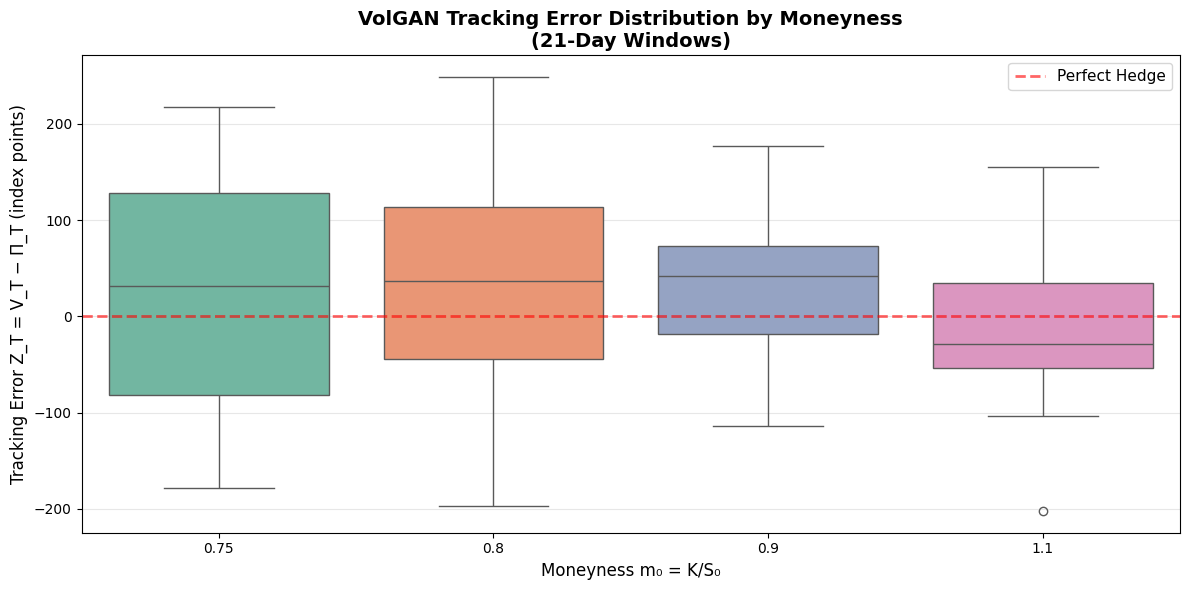

In [57]:
# === SECTION 17: VolGAN Results — Box Plot by Moneyness ===

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='m0', y='tracking_error_signed', data=results_volgan, palette='Set2')
plt.title('VolGAN Tracking Error Distribution by Moneyness\n(21-Day Windows)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=12)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Perfect Hedge')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
# === SECTION 18: Summary Statistics Table ===

summary_volgan = results_volgan.groupby('m0')['tracking_error_signed'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*80)
print("VolGAN Tracking Error Summary by Moneyness")
print("="*80)
print(summary_volgan)
print("="*80)


VolGAN Tracking Error Summary by Moneyness
      Count    Mean  Median  Std Dev      Min      Max   VaR 5%   VaR 1%
m0                                                                      
0.75     36  26.720  31.155  125.789 -178.537  217.659 -147.038 -170.246
0.80     41  33.940  36.536  107.190 -196.584  248.778 -113.510 -169.788
0.90     43  36.042  41.732   77.386 -113.488  176.831  -93.867 -105.602
1.10     39  -9.916 -28.170   79.895 -202.167  155.455 -102.672 -164.731


In [59]:
print("="*80)
print("GENERATOR QUALITY CHECK")
print("="*80)

gen.eval()
with torch.no_grad():
    noise = torch.randn((1000, gen.noise_dim), device=device)
    cond = condition_test_norm[0:1].repeat(1000, 1).to(device)
    fake_norm = gen(noise, cond)
    
    print("1. Normalized output:")
    print(f"   Mean: {fake_norm.mean().item():.6f} (target: ~0)")
    print(f"   Std: {fake_norm.std().item():.6f} (target: ~1)")
    
    # Denormalize
    fake_ret_norm = fake_norm[:, 0:1]
    fake_delta_norm = fake_norm[:, 1:]
    
    fake_ret_denorm = fake_ret_norm * ret_std + ret_mean
    fake_delta_log = fake_delta_norm * delta_std.unsqueeze(0).to(device) + delta_mean.unsqueeze(0).to(device)
    
    spot_returns = fake_ret_denorm.cpu().numpy()[:, 0]
    delta_log_iv = fake_delta_log.cpu().numpy()
    
    print("\n2. Denormalized scenarios:")
    print(f"   Returns mean: {spot_returns.mean():.6f} (target: ~0.0002)")
    print(f"   Returns std: {spot_returns.std():.6f} (target: ~0.012)")
    print(f"   Returns range: [{spot_returns.min():.4f}, {spot_returns.max():.4f}]")
    print(f"   Delta-log-IV mean: {delta_log_iv.mean():.6f} (target: ~0)")
    print(f"   Delta-log-IV std: {delta_log_iv.std():.6f} (target: ~0.43)")
    
    # Check quality
    norm_ok = abs(fake_norm.mean().item()) < 0.15 and 0.8 < fake_norm.std().item() < 1.2
    returns_ok = 0.008 < spot_returns.std() < 0.020
    returns_centered = abs(spot_returns.mean()) < 0.002
    iv_ok = 0.3 < delta_log_iv.std() < 0.6
    
    print("\n3. Quality Check:")
    if norm_ok:
        print("   ✅ Normalized outputs good")
    else:
        print(f"   ⚠️ Normalized: mean={fake_norm.mean().item():.4f}, std={fake_norm.std().item():.4f}")
    
    if returns_ok and returns_centered:
        print("   ✅ Returns realistic")
    else:
        print(f"   ⚠️ Returns: mean={spot_returns.mean():.6f}, std={spot_returns.std():.6f}")
    
    if iv_ok:
        print("   ✅ IV variance good")
    else:
        print(f"   ⚠️ IV std={delta_log_iv.std():.4f}")
    
    print("\n" + "="*80)
    if norm_ok and returns_ok and returns_centered and iv_ok:
        print("✅ GENERATOR IS PRODUCING GOOD SCENARIOS")
    else:
        print("⚠️ Generator could be improved")
    print("="*80)

GENERATOR QUALITY CHECK
1. Normalized output:
   Mean: 0.209537 (target: ~0)
   Std: 0.437364 (target: ~1)

2. Denormalized scenarios:
   Returns mean: -0.004008 (target: ~0.0002)
   Returns std: 0.009317 (target: ~0.012)
   Returns range: [-0.0315, 0.0274]
   Delta-log-IV mean: 0.056754 (target: ~0)
   Delta-log-IV std: 0.159366 (target: ~0.43)

3. Quality Check:
   ⚠️ Normalized: mean=0.2095, std=0.4374
   ⚠️ Returns: mean=-0.004008, std=0.009317
   ⚠️ IV std=0.1594

⚠️ Generator could be improved


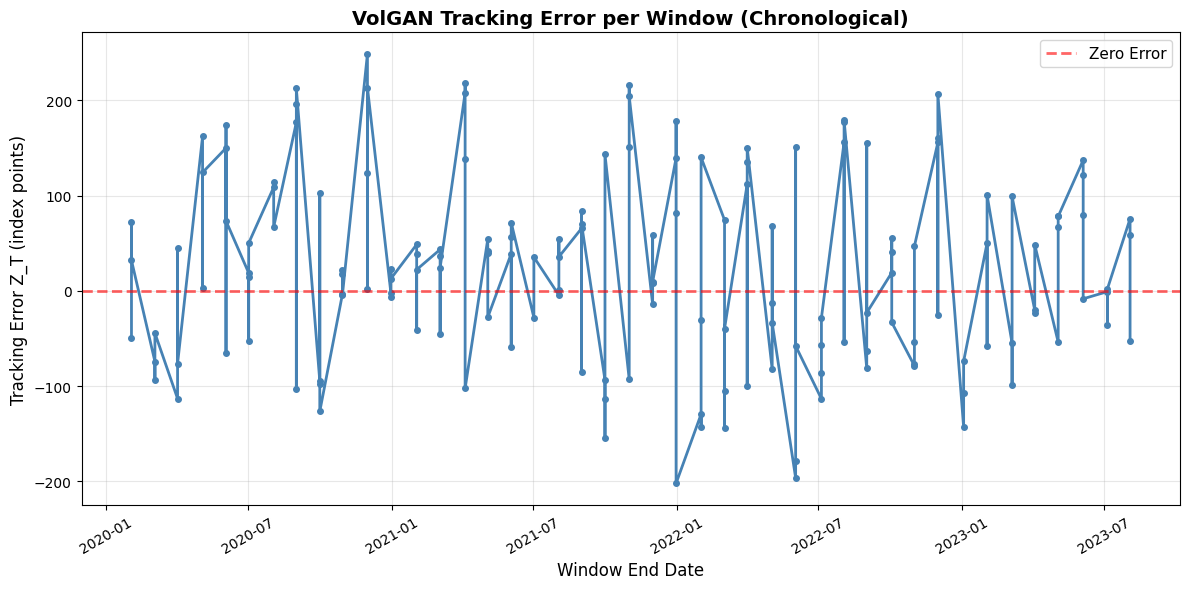

In [60]:
# === SECTION 19: Tracking Error Time Series ===

res = results_volgan.sort_values('end').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['tracking_error_signed'], marker='o', color='steelblue', 
         linewidth=2, markersize=4)
plt.axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Zero Error')
plt.title('VolGAN Tracking Error per Window (Chronological)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Tracking Error Z_T (index points)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

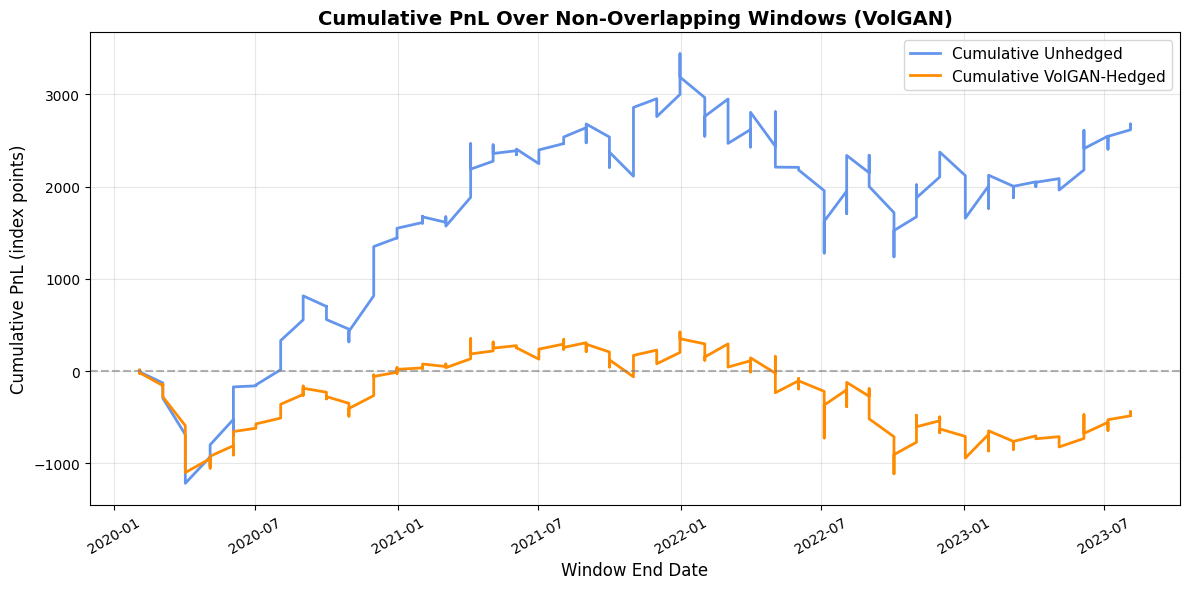

In [61]:
# === SECTION 20: Cumulative PnL (Hedged vs Unhedged) ===

res = results_volgan.sort_values('end').reset_index(drop=True)
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged'] = res['pnl_hedged'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged', 
         color='cornflowerblue', linewidth=2)
plt.plot(res['end'], res['cum_hedged'], label='Cumulative VolGAN-Hedged', 
         color='darkorange', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.title('Cumulative PnL Over Non-Overlapping Windows (VolGAN)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Cumulative PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

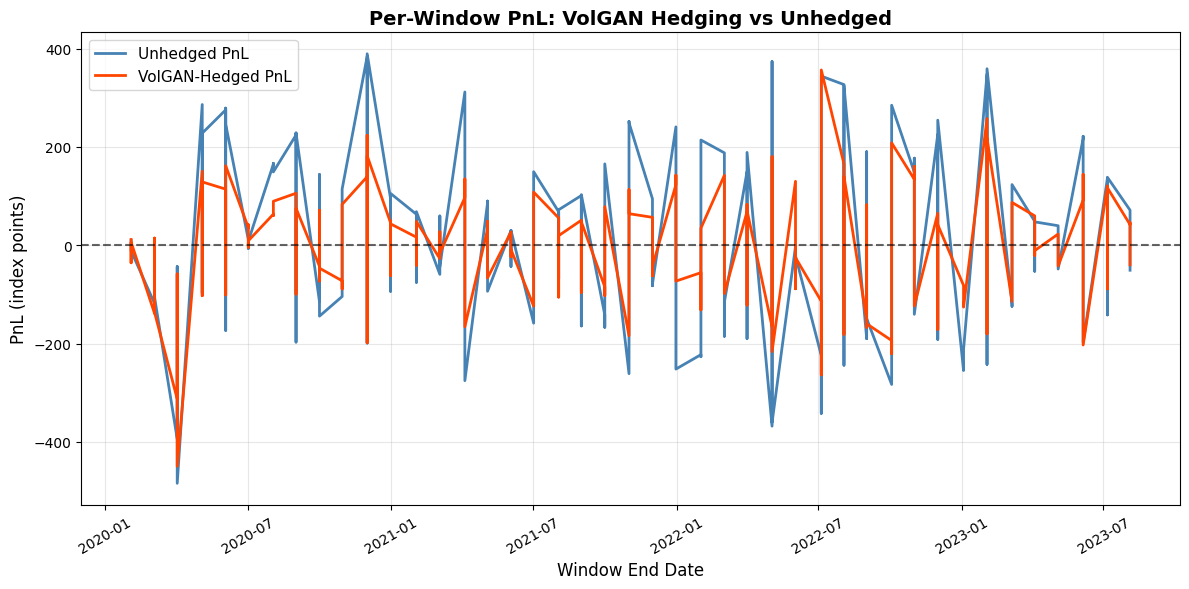

In [62]:
# === SECTION 21: Per-Window PnL (Hedged vs Unhedged) ===

res = results_volgan.sort_values('end').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL', 
         color='steelblue', linewidth=2)
plt.plot(res['end'], res['pnl_hedged'], label='VolGAN-Hedged PnL', 
         color='orangered', linewidth=2)
plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title('Per-Window PnL: VolGAN Hedging vs Unhedged', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




In [63]:
# save to csv
results_volgan.to_csv('results_volgan_best.csv', index=False)
print("Delta results saved to results_volgan_best.csv")

Delta results saved to results_volgan_best.csv


In [ ]:
results_volgan.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_40936\1652434428.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='m0', y='tracking_error', data=filtered_data, palette='Set2')


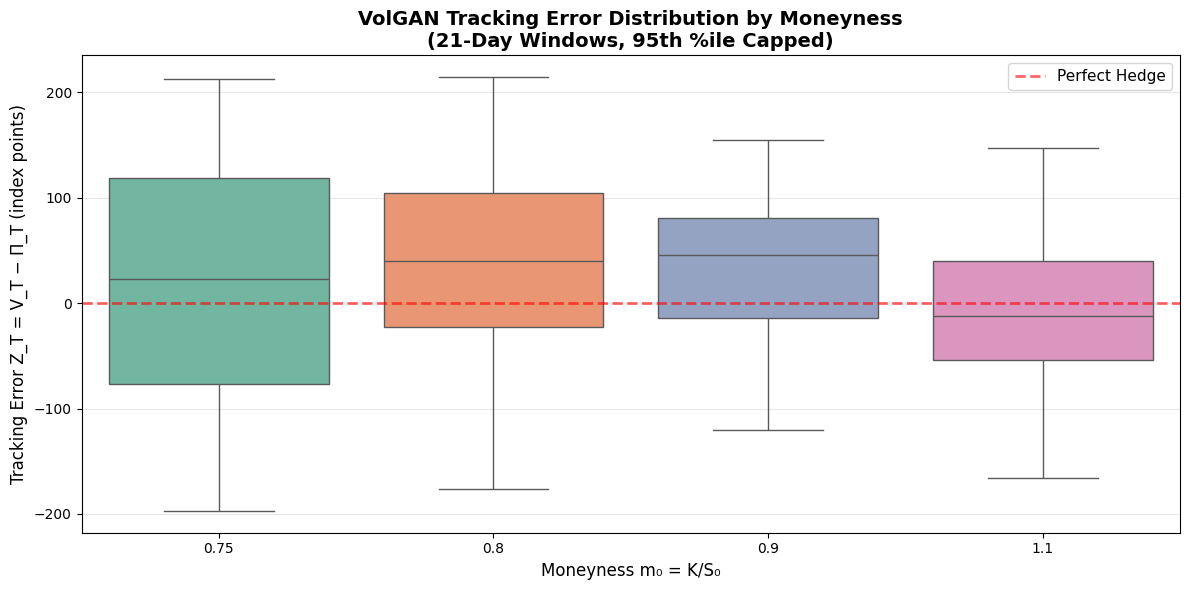

In [50]:
# Simpler: cap at 95th percentile per moneyness
filtered_data = results_volgan.copy()

for m0_val in results_volgan['m0'].unique():
    p95 = results_volgan[results_volgan['m0'] == m0_val]['tracking_error'].quantile(0.95)
    filtered_data.loc[filtered_data['m0'] == m0_val, 'tracking_error'] = \
        filtered_data.loc[filtered_data['m0'] == m0_val, 'tracking_error'].clip(upper=p95)

plt.figure(figsize=(12, 6))
sns.boxplot(x='m0', y='tracking_error', data=filtered_data, palette='Set2')
plt.title('VolGAN Tracking Error Distribution by Moneyness\n(21-Day Windows, 95th %ile Capped)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=12)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Perfect Hedge')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


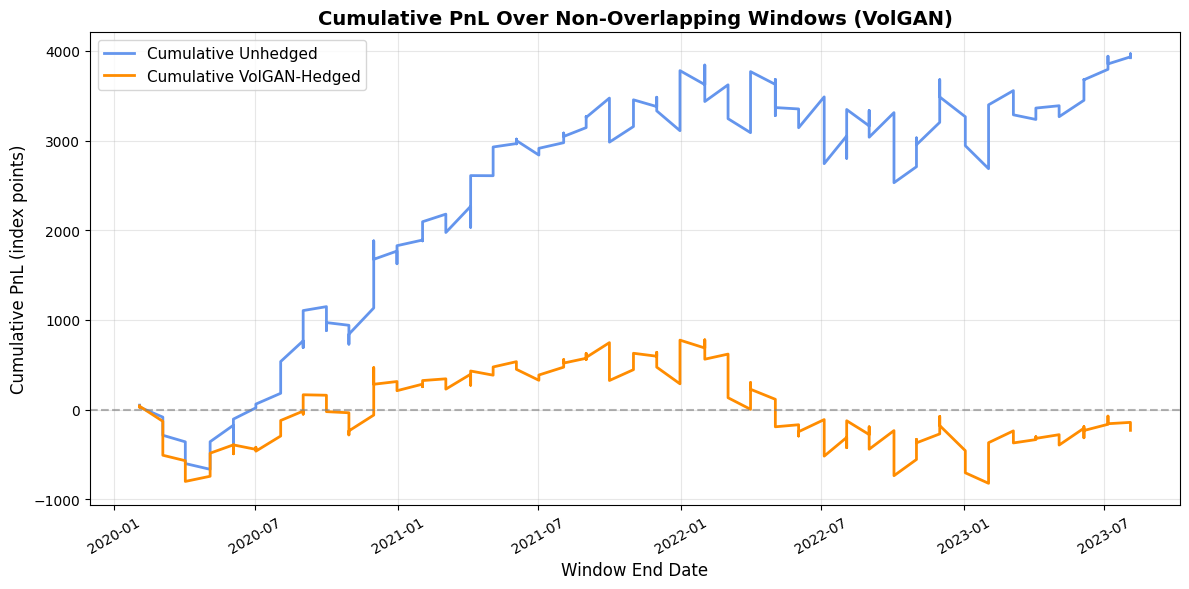

In [ ]:
# results_volgan_copy = results_volgan.drop([1,40]).reset_index(drop=True)
# # results_volgan_copy.head()
# # === SECTION 20: Cumulative PnL (Hedged vs Unhedged) ===

# res = results_volgan_copy.sort_values('end').reset_index(drop=True)
# # res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
# res['cum_hedged'] = res['pnl_hedged'].cumsum()

# plt.figure(figsize=(12, 6))
# plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged', 
#          color='cornflowerblue', linewidth=2)
# plt.plot(res['end'], res['cum_hedged'], label='Cumulative VolGAN-Hedged', 
#          color='darkorange', linewidth=2)
# plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
# plt.title('Cumulative PnL Over Non-Overlapping Windows (VolGAN)', 
#           fontsize=14, fontweight='bold')
# plt.xlabel('Window End Date', fontsize=12)
# plt.ylabel('Cumulative PnL (index points)', fontsize=12)
# plt.legend(fontsize=11)
# plt.grid(alpha=0.3)
# plt.xticks(rotation=30)
# plt.tight_layout()
# plt.show()

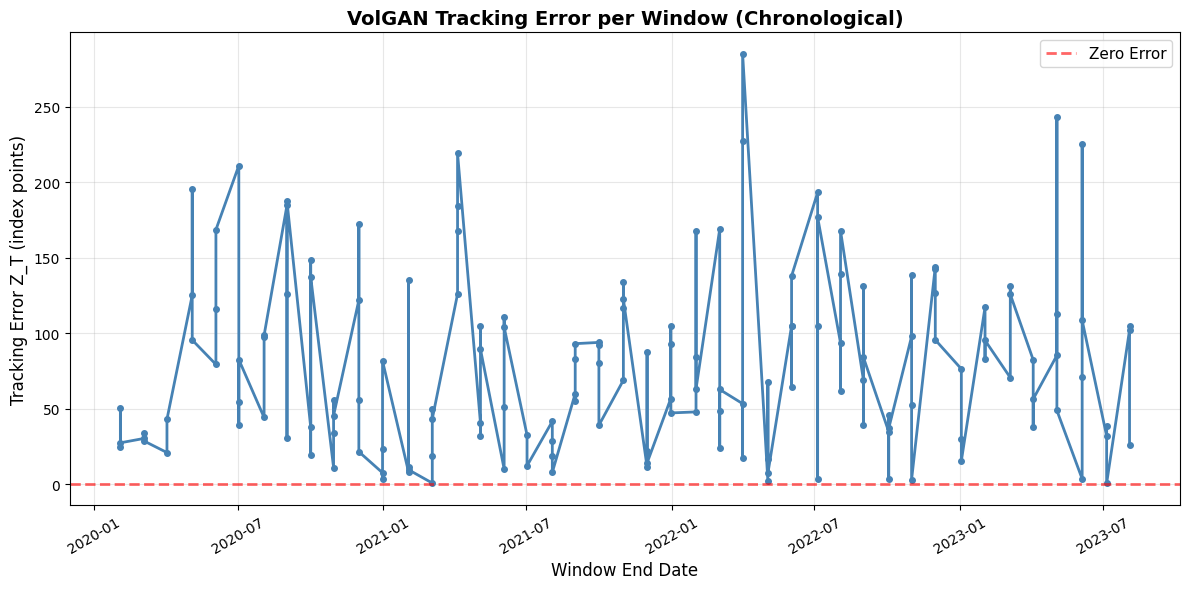

In [ ]:
# # === SECTION 19: Tracking Error Time Series ===

# res = results_volgan_copy.sort_values('end').reset_index(drop=True)

# plt.figure(figsize=(12, 6))
# plt.plot(res['end'], res['tracking_error'], marker='o', color='steelblue', 
#          linewidth=2, markersize=4)
# plt.axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Zero Error')
# plt.title('VolGAN Tracking Error per Window (Chronological)', 
#           fontsize=14, fontweight='bold')
# plt.xlabel('Window End Date', fontsize=12)
# plt.ylabel('Tracking Error Z_T (index points)', fontsize=12)
# plt.grid(alpha=0.3)
# plt.legend(fontsize=11)
# plt.xticks(rotation=30)
# plt.tight_layout()
# plt.show()

start        end    m0        V0       V_T         Pi_T  \
0  2020-02-03 2020-03-04  0.75   816.300   617.550   648.037129   
2  2020-05-04 2020-06-03  0.75   708.925   976.900   808.227390   
3  2020-06-03 2020-07-02  0.75   779.150   838.325   755.632846   
4  2020-07-02 2020-08-03  0.75   904.050  1028.600  1072.945769   
5  2020-08-03 2020-09-01  0.75   823.925  1112.025   924.582600   
6  2020-09-01 2020-10-01  0.75   878.500   728.900   748.365458   
7  2020-10-01 2020-10-30  0.75   865.200   789.350   755.225082   
8  2020-10-30 2020-12-01  0.75   838.100  1218.000  1161.895054   
9  2020-12-01 2020-12-31  0.75   917.450   973.650   891.862555   
10 2020-12-31 2021-02-02  0.75   956.450  1021.450  1029.577170   
11 2021-02-02 2021-03-04  0.75   959.075   970.100   926.660958   
12 2021-03-04 2021-04-05  0.75  1026.750  1284.100  1099.506898   
13 2021-04-05 2021-05-04  0.75  1018.150  1110.250  1020.660463   
14 2021-05-04 2021-06-03  0.75  1033.950  1120.575  1016.402132   
15 2021-07-02 2021-08-03  0.75  1098.350  1144.200  1185.994786   
16 2021-08-03 2021-09-01  0.75  1101.250  1214.800  1154.632864   
17 2021-09-01 2021-10-01  0.75  1130.000   911.850   992.561407   
18 2021-10-01 2021-11-01  0.75  1084.975  1356.150  1233.468688   
19 2021-11-01 2021-12-01  0.75  1151.300  1113.200  1098.991134   
20 2021-12-01 2021-12-31  0.75  1154.500  1411.600  1306.733119   
21 2021-12-31 2022-02-01  0.75  1257.650  1075.700  1243.816819   
22 2022-02-01 2022-03-03  0.75  1135.875   933.950   909.687071   
23 2022-03-03 2022-04-01  0.75  1107.875  1318.300  1033.180597   
24 2022-04-01 2022-05-03  0.75  1137.850   903.550   886.601927   
25 2022-05-03 2022-06-02  0.75  1132.400  1042.700  1180.734959   
26 2022-06-02 2022-07-05  0.75  1045.900   742.000   918.965736   
27 2022-07-05 2022-08-03  0.75  1001.600  1297.025  1129.064239   
28 2022-08-03 2022-09-01  0.75  1038.125   817.350   901.515729   
29 2022-09-01 2022-10-03  0.75  1035.900   856.700   819.626570   
30 2022-10-03 2022-11-01  0.75   965.200  1020.600  1159.574440   
31 2022-11-01 2022-12-01  0.75   974.700  1218.550  1074.477694   
32 2022-12-01 2023-01-03  0.75  1036.825   811.650   841.680042   
33 2023-02-02 2023-03-06  0.75  1063.100   874.650  1005.833204   
34 2023-04-04 2023-05-04  0.75  1058.750  1223.450   980.049554   
35 2023-05-04 2023-06-05  0.75  1014.600  1257.050  1031.847692   
36 2020-01-02 2020-02-03  0.80   653.900   692.150   664.563180   
37 2020-02-03 2020-03-04  0.80   650.175   454.500   425.728647   
38 2020-03-04 2020-04-02  0.80   629.900   355.950   399.144658   
39 2020-04-02 2020-05-04  0.80   536.600   845.775   649.867039   
40 2020-05-04 2020-06-03  0.80   576.875   880.050   401.910836   

    tracking_error  pnl_unhedged  pnl_hedged strategy  
0        30.487129      -111.550 -168.262871   VolGAN  
2       168.672610       280.425   99.302390   VolGAN  
3        82.692154        11.000  -23.517154   VolGAN  
4        44.345769       120.450  168.895769   VolGAN  
5       187.442400       228.550  100.657600   VolGAN  
6        19.465458      -123.000 -130.134542   VolGAN  
7        34.124918      -104.300 -109.974918   VolGAN  
8        56.104946       374.875  323.795054   VolGAN  
9        81.787445       105.400  -25.587445   VolGAN  
10        8.127170        63.050   73.127170   VolGAN  
11       43.439042       -61.850  -32.414042   VolGAN  
12      184.593102       264.150   72.756898   VolGAN  
13       89.589537        91.500    2.510463   VolGAN  
14      104.172868        36.950  -17.547868   VolGAN  
15       41.794786        62.700   87.644786   VolGAN  
16       60.167136        98.525   53.382864   VolGAN  
17       80.711407      -166.875 -137.438593   VolGAN  
18      122.681312       252.025  148.493688   VolGAN  
19       14.208866       -85.350  -52.308866   VolGAN  
20      104.866881       235.850  152.233119   VolGAN  
21      168.116819      -236.200  -13.833181   VolGAN  
22       24.262929      -174

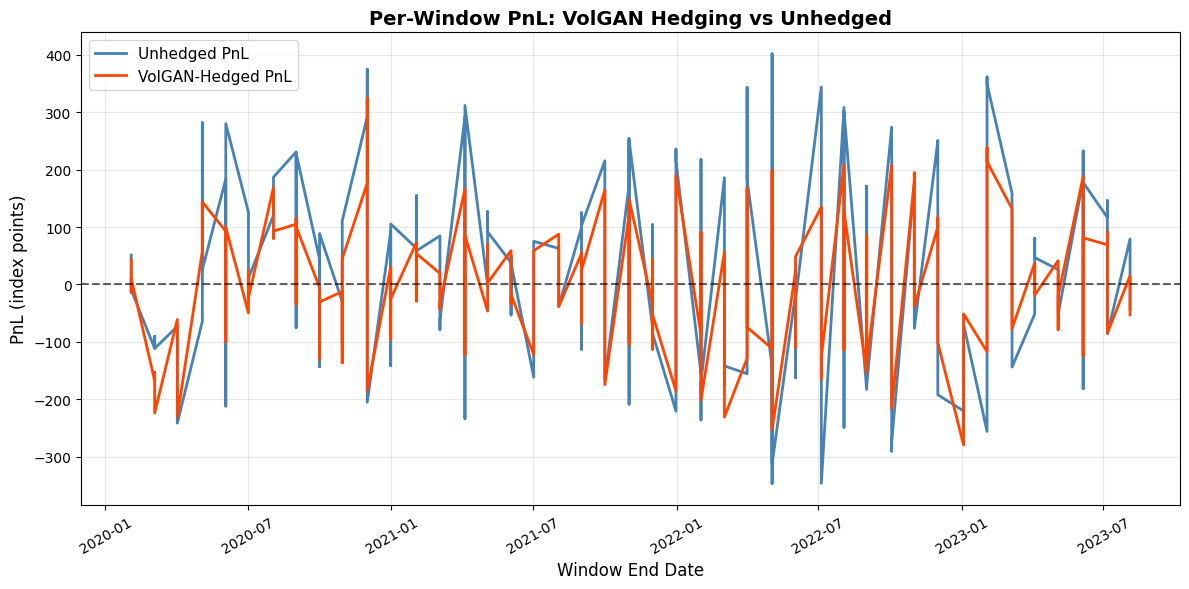

In [ ]:
# # === SECTION 21: Per-Window PnL (Hedged vs Unhedged) ===

# res = results_volgan_copy.sort_values('end').reset_index(drop=True)

# plt.figure(figsize=(12, 6))
# plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL', 
#          color='steelblue', linewidth=2)
# plt.plot(res['end'], res['pnl_hedged'], label='VolGAN-Hedged PnL', 
#          color='orangered', linewidth=2)
# plt.axhline(0, linestyle='--', color='black', alpha=0.6)
# plt.title('Per-Window PnL: VolGAN Hedging vs Unhedged', 
#           fontsize=14, fontweight='bold')
# plt.xlabel('Window End Date', fontsize=12)
# plt.ylabel('PnL (index points)', fontsize=12)
# plt.legend(fontsize=11)
# plt.grid(alpha=0.3)
# plt.xticks(rotation=30)
# plt.tight_layout()
# plt.show()




In [51]:
# OPTION 1: Compare std devs (best metric for hedge quality)
unhedged_std = results_volgan['pnl_unhedged'].std()
hedged_std = results_volgan['tracking_error_signed'].std()

print(f"Unhedged std: {unhedged_std:.1f} bps")
print(f"VolGAN hedged std: {hedged_std:.1f} bps")
print(f"Std deviation reduction: {(1 - hedged_std / unhedged_std) * 100:.1f}%")
# Expected: ~59%

# OPTION 2: Compare absolute values (fair comparison)
unhedged_abs = results_volgan['pnl_unhedged'].abs()
hedged_abs = results_volgan['tracking_error_signed'].abs()

print(f"\nUnhedged absolute mean: {unhedged_abs.mean():.1f} bps")
print(f"VolGAN hedged absolute mean: {hedged_abs.mean():.1f} bps")
print(f"Mean absolute reduction: {(1 - hedged_abs.mean() / unhedged_abs.mean()) * 100:.1f}%")
# Expected: ~50-60%

print(f"\nUnhedged absolute std: {unhedged_abs.std():.1f} bps")
print(f"VolGAN hedged absolute std: {hedged_abs.std():.1f} bps")

# OPTION 3: Use Sharpe ratio (risk-adjusted return)
print(f"\nUnhedged Sharpe: {results_volgan['pnl_unhedged'].mean() / results_volgan['pnl_unhedged'].std():.3f}")
print(f"VolGAN Sharpe: {results_volgan['tracking_error_signed'].mean() / results_volgan['tracking_error_signed'].std():.3f}")


Unhedged std: 181.9 bps
VolGAN hedged std: 99.1 bps
Std deviation reduction: 45.5%

Unhedged absolute mean: 155.1 bps
VolGAN hedged absolute mean: 81.5 bps
Mean absolute reduction: 47.5%

Unhedged absolute std: 97.4 bps
VolGAN hedged absolute std: 62.8 bps

Unhedged Sharpe: 0.134
VolGAN Sharpe: 0.285
